### imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import Circle
%matplotlib inline

In [2]:
from sympy import Matrix, symbols, tan, cos, sin, latex
from IPython.display import display, Math, clear_output

x, y, w, v, a, st, L = symbols('x y psi v a delta L')

In [3]:
from control import lqr, dlqr
from scipy.integrate import odeint


In [4]:
import gurobipy as gp
from gurobipy import GRB

# System

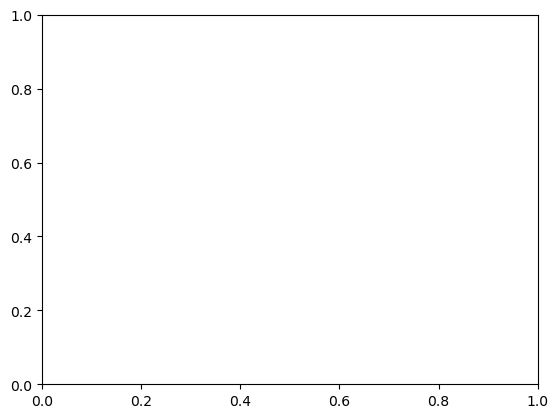

In [46]:
from pettingzoo.custom import simple_reach_v3

p_env = simple_reach_v3.env(
            seed=None,
            render_mode="rgb_array",
            num_obstacles=1,
            obstacle_size=6,
            continuous_actions=True,
            max_cycles=250)

([], [])

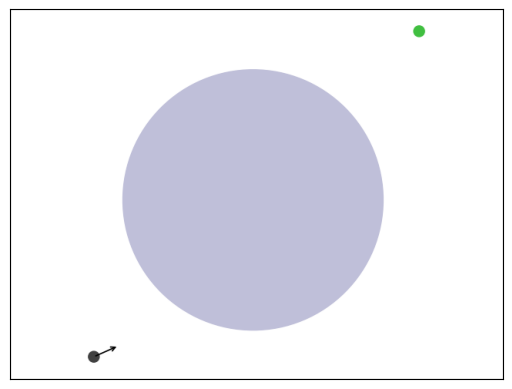

In [50]:
p_env.reset()
plt.imshow(p_env.render())
plt.xticks([]); plt.yticks([])

global variables from the env

In [51]:
dt = 0.1 
max_accel = 1.0
max_steer = np.pi / 18 # 6
wheelbase = 0.5
# max_speed


# Dynamics

In [52]:
states = Matrix([x, y, w, v])
inputs = Matrix([a, st])
function = Matrix([v * cos(w), v * sin(w), v * tan(st) / L, a])

In [53]:
display(Math('states =' + latex(states) + ',\; inputs =' + latex(inputs) + ',\; f(x, u) =' + latex(function)))

<IPython.core.display.Math object>

#### Linearisation

In [54]:
A = function.jacobian(states)
B = function.jacobian(inputs)

In [55]:
display(Math('A =' + latex(A) + ',\; B =' + latex(B)))

<IPython.core.display.Math object>

### Discretisation (not required)

In [56]:
Ad = np.eye(4) + A * dt + 0.5 * (A * dt) ** 2
Bd = dt * B + 0.5 * (A * dt ** 2) @ B

In [57]:
display(Math('A_d =' + latex(Ad) + ',\; B_d =' + latex(Bd)))

<IPython.core.display.Math object>

# LQR 
**in PettingZoo Env**

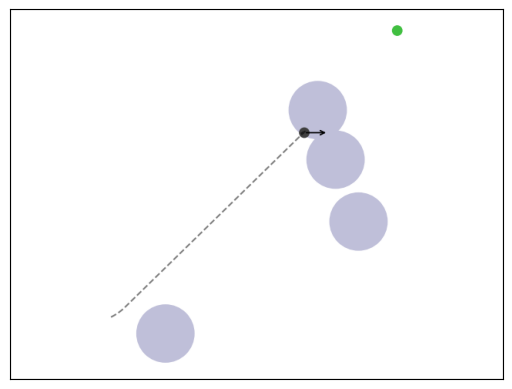

KeyboardInterrupt: 

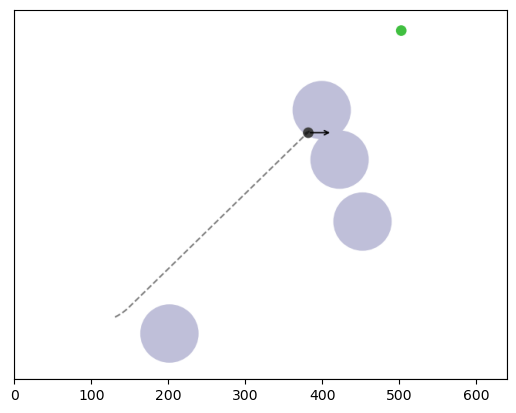

In [14]:
p_env.reset()

xf = np.array([*p_env.world.landmarks[0].state.p_pos, 1e-6, 1e-6])
x0 = p_env.get_agent_states() # 0th agent
xs, us = x0.copy().reshape(1, -1), np.array([[1e-6, 1e-6]])

Q = np.diag([10/ 20, 10 / 20, 0, 5 / 10])
R = np.diag([4 / 2, 0.01 / np.pi / 3]) #np.diag([0.001, 0.1])

for _ in p_env.agent_iter():
    
    observation, reward, termination, truncation, info = p_env.last()
    if termination or truncation:
        u = None
        break
    else:
        x_t = p_env.get_agent_states()
        Ad_t = np.array(Ad.subs(zip(states, x_t + 1e-6)
                        ).subs(zip(inputs, [1e-6, 1e-6])       
                        ).subs(L, wheelbase), dtype=np.float32)
        Bd_t = np.array(Bd.subs(zip(states, x_t + 1e-6)
                        ).subs(zip(inputs, [1e-6, 1e-6])
                        ).subs(L, wheelbase), dtype=np.float32) 

        # LQR
        Kd, _, _ = dlqr(Ad_t, Bd_t, Q, R)
        u_t = -Kd @ np.subtract(x_t, xf)
        u_t = np.clip(u_t, [-max_accel, -max_steer], 
                    [max_accel, max_steer]).astype(np.float32)


    p_env.step(u_t)

    xs = np.vstack([xs, x_t])
    us = np.vstack([us, u_t])
    
    plt.gca().clear()
    plt.imshow(p_env.render())
    # plt.axis('equal')
    plt.xticks([])
    plt.yticks([])
    clear_output(wait=True)
    display(plt.gcf())


**define control affine form (approximated)**

In [58]:
def ff(s):
    return np.array([[s[3] * np.cos(s[2])], 
                     [s[3] * np.sin(s[2])], 
                     [1e-4], [1e-4]])
def gg(s):
    return np.array([[1e-4, 1e-4],
                     [1e-4, 1e-4],
                     [1e-4, s[3] / wheelbase],
                     [1, 1e-4]])
print(np.pi / 18 - np.tan(np.pi / 18))

-0.0017940555090320276


# CBF-QP (non-linear)
**using `gurobipy`**

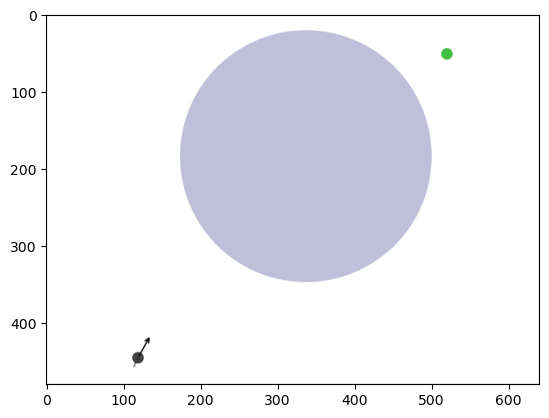

ERROR: No feasible solution found!


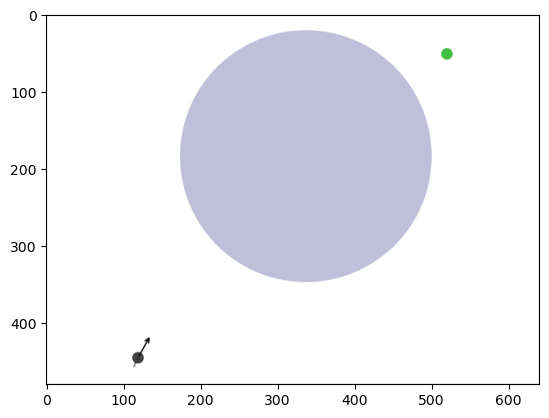

In [67]:
p_env.reset(seed=None) # 101, 111, 1111, 11111

xf = np.array([*p_env.world.landmarks[0].state.p_pos, 1e-6, 1e-6])
x0 = p_env.get_agent_states() # 0th agent
u_t = np.array([1e-6, 1e-6])
xs = x0.copy().reshape(1, -1)
us = u_t.copy().reshape(1, -1)

m = gp.Model("QP")
m.Params.DualReductions = 1
m.Params.FeasibilityTol = 1e-9
m.Params.LogToConsole = 0

uu = m.addMVar(shape=(2,), 
              lb=np.array([-max_accel, -max_steer]), 
              ub=np.array([max_accel, max_steer]), name='u')
# ud = m.addMVar(shape=(2,), lb=-GRB.INFINITY, name='ud')
slack = m.addVar(name='slack')

# control parameters
H = np.diag([1, 1])
Q = np.diag([10 / 20, 10 / 20, 0, 10 / 10])
R = np.diag([4 / 2, 0.1 / np.pi / 3]) #np.diag([0.001, 0.1])
c = 2e-1#5e-1
p = 1e10#1e10

''' working control parameters 
# env seed = 7 num obstacles 5 with size 1.5
Q = np.diag([10 / 20, 10 / 20, 0, 1 / 10])
R = np.diag([4 / 2, 1 / np.pi / 3]) #np.diag([0.001, 0.1])
c = 1.25
p = 2e1

# env seed = 7 num obstacles 3 with size 2
Q = np.diag([10 / 20, 10 / 20, 0, 1 / 10])
R = np.diag([4 / 2, 1 / np.pi / 3]) #np.diag([0.001, 0.1])
c = 1
p = 1e2
# '''

costs = []
usafes = np.zeros(2) + 1e-5
slacks = []
debug = [{'h': [], 'dh0': [], 'dh1': [], 'Lf_h': [], 'Lg_h0': [], 'Lg_h1': []} 
            for _ in range(len(p_env.world.landmarks) - 1)]


for _ in p_env.agent_iter():
    
    observation, reward, termination, truncation, info = p_env.last()
    if termination or truncation:
        u_t = None
        break
    x_t = p_env.get_agent_states()

    A_t = np.array(A.subs(zip(states, x_t + 1e-6)
                    ).subs(zip(inputs, u_t + 1e-6)       
                    ).subs(L, wheelbase), dtype=np.float32) + 1e-6
    B_t = np.array(B.subs(zip(states, x_t + 1e-6)
                    ).subs(zip(inputs, u_t + 1e-6)
                    ).subs(L, wheelbase), dtype=np.float32) + 1e-6
    K, _, _ = lqr(A_t, B_t, Q, R)
    u_t = -K @ np.subtract(x_t, xf)
    u_t = np.clip(u_t, [-max_accel, -max_steer], 
                [max_accel, max_steer]).astype(np.float32)
    '''
    # Discrete LQR
    # Ad_t = np.array(Ad.subs(zip(states, x_t + 1e-6)
    #                 ).subs(zip(inputs, u_t + 1e-6)#[1e-6, 1e-6])     
    #                 ).subs(L, wheelbase), dtype=np.float32)
    # Bd_t = np.array(Bd.subs(zip(states, x_t + 1e-6)
    #                 ).subs(zip(inputs, u_t + 1e-6)#[1e-6, 1e-6])
    #                 ).subs(L, wheelbase), dtype=np.float32) 
    # Kd, _, _ = dlqr(Ad_t, Bd_t, Q, R)
    # u_t = -Kd @ np.subtract(x_t, xf)
    # u_t = np.clip(u_t, [-max_accel, -max_steer], 
    #             [max_accel, max_steer]).astype(np.float32)
    '''

    # us = np.vstack([us, u_t])

    # CBF
    h_min = float('inf')
    for i, o in enumerate(p_env.world.landmarks[1:]):
        dist = np.sum(np.square(x_t[:2] - o.state.p_pos))
        h = (o.size + wheelbase) ** 2 - dist# + p_env.world.contact_margin)
        dh = -2 * np.array([*(x_t[:2] - o.state.p_pos), 1e-4, 1e-4])
        Lf_h = (dh @ ff(x_t))[0] #
        Lg_h = dh @ gg(x_t)#
       
        debug[i]['h'].append(h)
        debug[i]['dh0'].append(dh[0])
        debug[i]['dh1'].append(dh[1])
        debug[i]['Lf_h'].append(Lf_h)
        debug[i]['Lg_h0'].append(Lg_h[0])
        debug[i]['Lg_h1'].append(Lg_h[1])
        
        # with open('.txt', 'a') as f:
        #     # f.write(f"{debug[i]['Lf_h']} + {debug[i]['Lf_h']} * u0 + {debug[i]['Lf_g0']} * u1 >= - {c} * {h}")
        #     if i == 0:
        #         f.write('\n')
        #     f.write(f"{Lf_h:.3f} + {Lg_h[0]:.3f} * u0 + {Lg_h[1]:.3f} * u1 >= - {c} * {h:.3f}\n")
            
        m.addConstr(Lf_h + Lg_h @ uu <= -c * h - slack, 
                    name='cbf_' + str(i))
    
    # m.addConstr(ud == uu - u_t, name='u_diff')
    obj = sum((uu - u_t) * (uu - u_t))
    # obj = (uu - u_t) @ H @ (uu - u_t)
    obj2 = p * slack
    m.setObjective(0.5 * obj + obj2, GRB.MINIMIZE)
    m.optimize()
    
    # with open('debug_cbf_gb.txt', 'a') as f:
    #     for const in m.getConstrs():
    #         f.write(f"{const.ConstrName} {const.rhs}\n")
    #     f.write(f"x(t) = {x_t}\nu(t) = {u_t}\n\n")

    if m.status == GRB.INFEASIBLE:
        plt.gca().clear()
        plt.imshow(p_env.render())
        # plt.xticks([]); plt.yticks([])
        display(plt.gcf())
        # clear_output(wait=True)
        print('ERROR: No feasible solution found!')
        
        break
    
    costs.append(m.getObjective().getValue())
    u_safe = [m.getVarByName(f"u[{i}]").X for i in range(2)]
    u_t = np.array(u_safe, dtype=np.float32)
    try: slacks.append(m.getVarByName(f"slack").X)
    except: pass  
    m.remove(m.getConstrs())

    p_env.step(u_t)

    xs = np.vstack([xs, x_t])
    usafes = np.vstack([usafes, u_t])
    
    plt.gca().clear()
    plt.imshow(p_env.render())
    plt.xticks([]); plt.yticks([])
    display(plt.gcf())
    clear_output(wait=True)

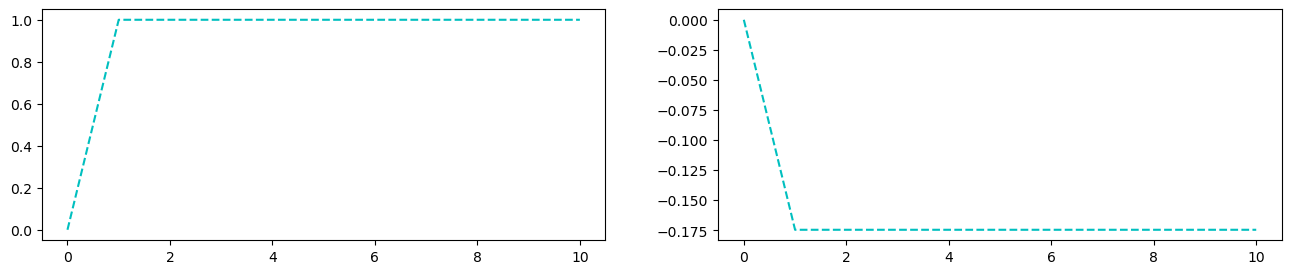

In [68]:
plt.figure(figsize=(16, 3))
plt.subplot(121)
plt.plot(us[:, 0], 'y')
plt.plot(usafes[:, 0], '--c')
plt.subplot(122)
plt.plot(us[:, 1], 'y')
plt.plot(usafes[:, 1], '--c')

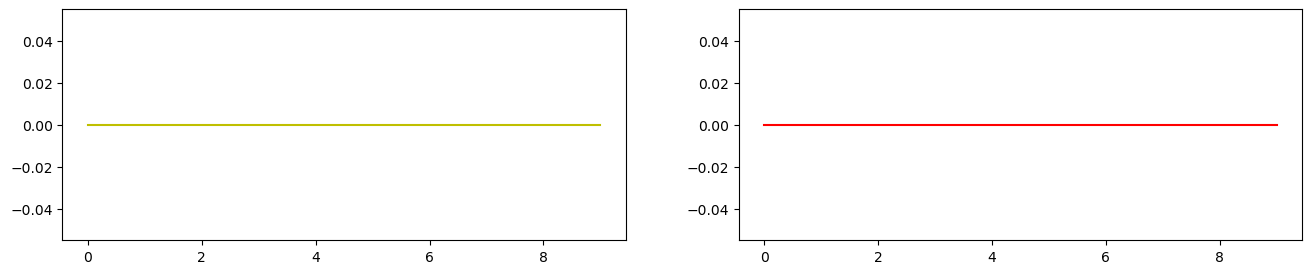

In [69]:
plt.figure(figsize=(16, 3))
plt.subplot(121)
plt.plot(costs, 'y')
plt.subplot(122)
plt.plot(slacks, 'r')

**debugging graphs**

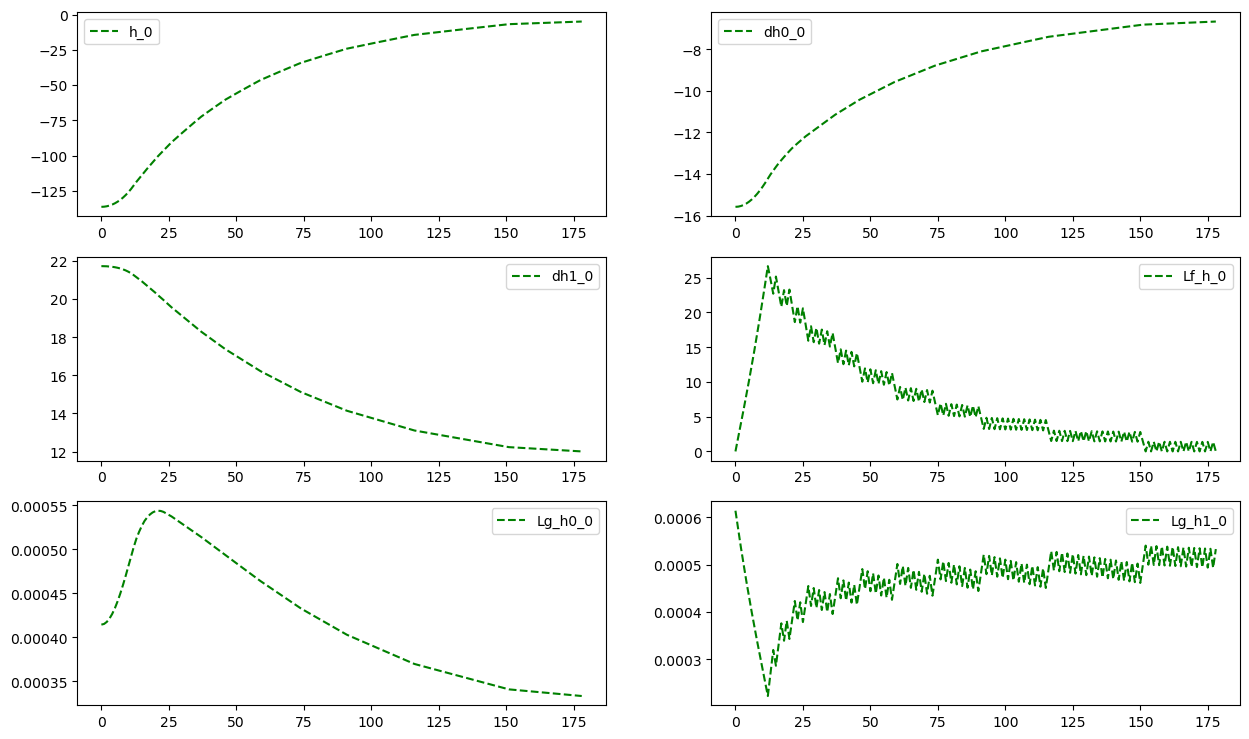

In [66]:
plt.figure(figsize=(15, 9))
plt.subplot(321)
for i in range(len(debug)):
    plt.plot(debug[i]['h'], '--' + 'grbmcyk'[i], label='h_' + str(i))
    plt.legend()
plt.subplot(322)
for i in range(len(debug)):
    plt.plot(debug[i]['dh0'], '--' + 'grbmcyk'[i], label='dh0_' + str(i))
    plt.legend()
plt.subplot(323)
for i in range(len(debug)):
    plt.plot(debug[i]['dh1'], '--' + 'grbmcyk'[i], label='dh1_' + str(i))
    plt.legend()
plt.subplot(324)
for i in range(len(debug)):
    plt.plot(debug[i]['Lf_h'], '--' + 'grbmcyk'[i], label='Lf_h_' + str(i))
    plt.legend()
plt.subplot(325)
for i in range(len(debug)):
    plt.plot(debug[i]['Lg_h0'], '--' + 'grbmcyk'[i], label='Lg_h0_' + str(i))
    plt.legend()
plt.subplot(326)
for i in range(len(debug)):
    plt.plot(debug[i]['Lg_h1'], '--' + 'grbmcyk'[i], label='Lg_h1_' + str(i))
    plt.legend()

---
# CBF-QP (Linear) 
**doesn't work due to being highly non-linear**

In [27]:
p_env.reset(seed=None) # 101, 111, 1111, 11111

xf = np.array([*p_env.world.landmarks[0].state.p_pos, 1e-6, 1e-6])
x0 = p_env.get_agent_states() # 0th agent
u_t = np.array([1e-6, 1e-6])
xs = x0.copy().reshape(1, -1)
us = u_t.copy().reshape(1, -1)

m = gp.Model("QP")
m.Params.DualReductions = 1
m.Params.FeasibilityTol = 1e-9
m.Params.LogToConsole = 0

uu = m.addMVar(shape=(2,), 
              lb=np.array([-max_accel, -max_steer]), 
              ub=np.array([max_accel, max_steer]), name='u')
# ud = m.addMVar(shape=(2,), lb=-GRB.INFINITY, name='ud')
slack = m.addVar(name='slack')

# control parameters
H = np.diag([1, 1])
Q = np.diag([10 / 20, 10 / 20, 0, 10 / 10])
R = np.diag([4 / 2, 0.1 / np.pi / 3]) #np.diag([0.001, 0.1])
c = 2.1
p = 1e8

''' working control parameters 
# env seed = 7 num obstacles 5 with size 1.5
Q = np.diag([10 / 20, 10 / 20, 0, 1 / 10])
R = np.diag([4 / 2, 1 / np.pi / 3]) #np.diag([0.001, 0.1])
c = 1.25
p = 2e1

# env seed = 7 num obstacles 3 with size 2
Q = np.diag([10 / 20, 10 / 20, 0, 1 / 10])
R = np.diag([4 / 2, 1 / np.pi / 3]) #np.diag([0.001, 0.1])
c = 1
p = 1e2
# '''

costs = []
usafes = np.zeros(2) + 1e-5
slacks = []
debug = [{'h': [], 'dh0': [], 'dh1': [], 'Lf_h': [], 'Lg_h0': [], 'Lg_h1': []} 
            for _ in range(len(p_env.world.landmarks) - 1)]


for _ in p_env.agent_iter():
    
    observation, reward, termination, truncation, info = p_env.last()
    if termination or truncation:
        u_t = None
        break
    x_t = p_env.get_agent_states()

    A_t = np.array(A.subs(zip(states, x_t + 1e-6)
                    ).subs(zip(inputs, u_t + 1e-6)       
                    ).subs(L, wheelbase), dtype=np.float32) + 1e-6
    B_t = np.array(B.subs(zip(states, x_t + 1e-6)
                    ).subs(zip(inputs, u_t + 1e-6)
                    ).subs(L, wheelbase), dtype=np.float32) + 1e-6
    K, _, _ = lqr(A_t, B_t, Q, R)
    u_t = -K @ np.subtract(x_t, xf)
    u_t = np.clip(u_t, [-max_accel, -max_steer], 
                [max_accel, max_steer]).astype(np.float32)
    # Discrete LQR
    # Ad_t = np.array(Ad.subs(zip(states, x_t + 1e-6)
    #                 ).subs(zip(inputs, u_t + 1e-6)#[1e-6, 1e-6])     
    #                 ).subs(L, wheelbase), dtype=np.float32)
    # Bd_t = np.array(Bd.subs(zip(states, x_t + 1e-6)
    #                 ).subs(zip(inputs, u_t + 1e-6)#[1e-6, 1e-6])
    #                 ).subs(L, wheelbase), dtype=np.float32) 
    # Kd, _, _ = dlqr(Ad_t, Bd_t, Q, R)
    # u_t = -Kd @ np.subtract(x_t, xf)
    # u_t = np.clip(u_t, [-max_accel, -max_steer], 
    #             [max_accel, max_steer]).astype(np.float32)

    us = np.vstack([us, u_t])

    # CBF
    h_min = float('inf')
    for i, o in enumerate(p_env.world.landmarks[1:]):
        dist = np.sum(np.square(x_t[:2] - o.state.p_pos))
        h = (o.size + wheelbase) ** 2 - dist# + p_env.world.contact_margin)
        dh = -2 * np.array([*(x_t[:2] - o.state.p_pos), 1e-4, 1e-4])
        Lf_h = dh @ A_t @ x_t #
        Lg_h = dh @ B_t#
       
        debug[i]['h'].append(h)
        debug[i]['dh0'].append(dh[0])
        debug[i]['dh1'].append(dh[1])
        debug[i]['Lf_h'].append(Lf_h)
        debug[i]['Lg_h0'].append(Lg_h[0])
        debug[i]['Lg_h1'].append(Lg_h[1])
        
        # with open('.txt', 'a') as f:
        #     # f.write(f"{debug[i]['Lf_h']} + {debug[i]['Lf_h']} * u0 + {debug[i]['Lf_g0']} * u1 >= - {c} * {h}")
        #     if i == 0:
        #         f.write('\n')
        #     f.write(f"{Lf_h:.3f} + {Lg_h[0]:.3f} * u0 + {Lg_h[1]:.3f} * u1 >= - {c} * {h:.3f}\n")
            
        m.addConstr(Lf_h + Lg_h @ uu <= -c * h + slack, 
                    name='cbf_' + str(i))
    
    # m.addConstr(ud == uu - u_t, name='u_diff')
    # obj = sum((uu - u_t) * (uu - u_t))
    obj = (uu - u_t) @ H @ (uu - u_t)
    obj2 = p * slack
    m.setObjective(0.5 * obj + obj2, GRB.MINIMIZE)
    m.optimize()
    
    # with open('debug_cbf_gb.txt', 'a') as f:
    #     for const in m.getConstrs():
    #         f.write(f"{const.ConstrName} {const.rhs}\n")
    #     f.write(f"x(t) = {x_t}\nu(t) = {u_t}\n\n")

    if m.status == GRB.INFEASIBLE:
        plt.gca().clear()
        plt.imshow(p_env.render())
        # plt.xticks([]); plt.yticks([])
        display(plt.gcf())
        # clear_output(wait=True)
        print('ERROR: No feasible solution found!')
        
        break
    
    costs.append(m.getObjective().getValue())
    u_safe = [m.getVarByName(f"u[{i}]").X for i in range(2)]
    u_t = np.array(u_safe, dtype=np.float32)
    try: slacks.append(m.getVarByName(f"slack").X)
    except: pass  
    m.remove(m.getConstrs())

    p_env.step(u_t)

    xs = np.vstack([xs, x_t])
    usafes = np.vstack([usafes, u_t])
    
    plt.gca().clear()
    plt.imshow(p_env.render())
    # plt.xticks([]); plt.yticks([])
    display(plt.gcf())
    clear_output(wait=True)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x15dc1ad40> (for post_execute):


IndexError: list index out of range

IndexError: list index out of range

<Figure size 640x480 with 1 Axes>

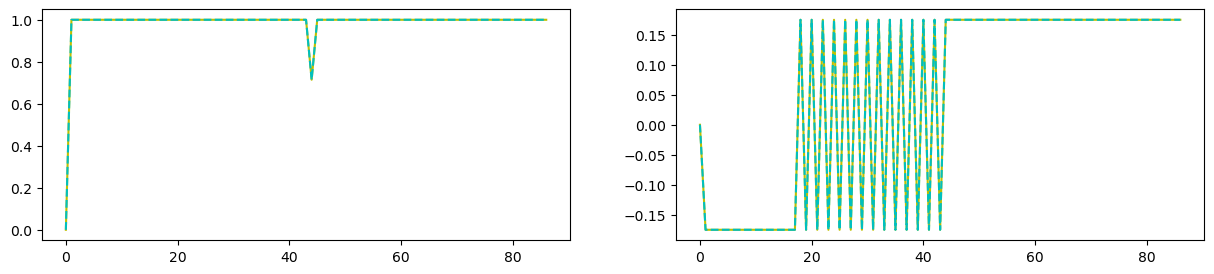

In [28]:
plt.figure(figsize=(15, 3))
plt.subplot(121)
plt.plot(us[:, 0], 'y')
plt.plot(usafes[:, 0], '--c')
plt.subplot(122)
plt.plot(us[:, 1], 'y')
plt.plot(usafes[:, 1], '--c')

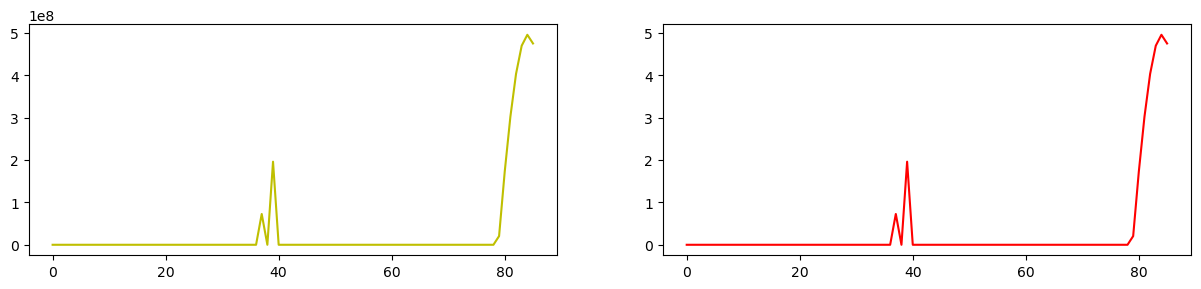

In [29]:
plt.figure(figsize=(15, 3))
plt.subplot(121)
plt.plot(costs, 'y')
plt.subplot(122)
plt.plot(slacks, 'r')

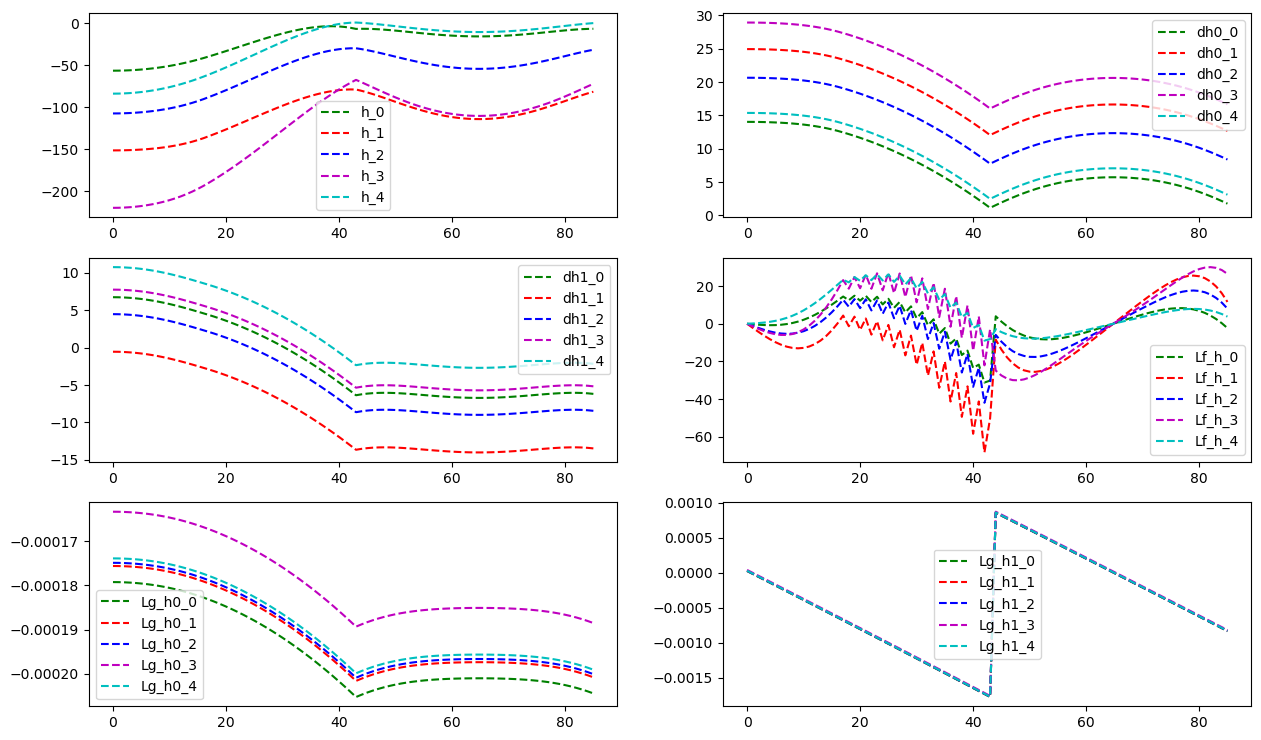

In [30]:
plt.figure(figsize=(15, 9))
plt.subplot(321)
for i in range(len(debug)):
    plt.plot(debug[i]['h'], '--' + 'grbmcyk'[i], label='h_' + str(i))
    plt.legend()
plt.subplot(322)
for i in range(len(debug)):
    plt.plot(debug[i]['dh0'], '--' + 'grbmcyk'[i], label='dh0_' + str(i))
    plt.legend()
plt.subplot(323)
for i in range(len(debug)):
    plt.plot(debug[i]['dh1'], '--' + 'grbmcyk'[i], label='dh1_' + str(i))
    plt.legend()
plt.subplot(324)
for i in range(len(debug)):
    plt.plot(debug[i]['Lf_h'], '--' + 'grbmcyk'[i], label='Lf_h_' + str(i))
    plt.legend()
plt.subplot(325)
for i in range(len(debug)):
    plt.plot(debug[i]['Lg_h0'], '--' + 'grbmcyk'[i], label='Lg_h0_' + str(i))
    plt.legend()
plt.subplot(326)
for i in range(len(debug)):
    plt.plot(debug[i]['Lg_h1'], '--' + 'grbmcyk'[i], label='Lg_h1_' + str(i))
    plt.legend()

In [152]:
ff(x_t)

array([[ 3.10682361e-01],
       [-1.23146133e+00],
       [ 1.00000000e-06],
       [ 1.00000000e-06]])

In [148]:
(A_t @ x_t).reshape(-1, 1)

array([[ 2.69375034e+00],
       [-7.48355774e-01],
       [ 4.47884325e-01],
       [-2.97424407e-07]])

In [352]:
print('all constraints')
for const in m.getConstrs():
    print(const.ConstrName, const.rhs)
    
m.getConstrByName('cbf_0').rhs

all constraints
cbf_0 -0.08080498530398379
cbf_1 -0.5617003281724675
cbf_2 -1.2726999274793558


-0.08080498530398379

# Learn the same CBF

In [1]:
import torch
from torch import nn
from torchsummary import summary
from torch.autograd.functional import jacobian as torch_autodiff

import numpy as np
import matplotlib.pyplot as plt

**Dataset**

In [50]:
N = 10_000 # total number of samples
np.random.seed(11)
samples = np.random.uniform(
    low=(-20, -20, -np.pi, -5), 
    high=(20, 20, np.pi, 5),  
    size=(N, 4)).astype(np.float32)

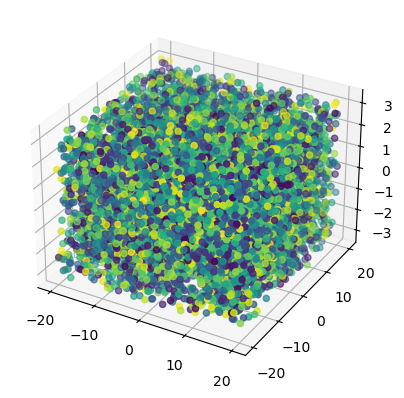

In [51]:
ax = plt.axes(projection='3d')
ax.scatter3D(samples[:, 0], samples[:, 1], samples[:, 2], c=samples[:, 3])

**Model**

In [91]:
model = nn.Sequential(
    nn.Linear(4, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Flatten(0, 1)
)

In [92]:
summary(model, (5000, 4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 5000, 64]             320
              ReLU-2             [-1, 5000, 64]               0
            Linear-3             [-1, 5000, 64]           4,160
              ReLU-4             [-1, 5000, 64]               0
            Linear-5              [-1, 5000, 1]              65
           Flatten-6                    [-1, 1]               0
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.08
Forward/backward pass size (MB): 9.80
Params size (MB): 0.02
Estimated Total Size (MB): 9.90
----------------------------------------------------------------


In [93]:
xcs, ycs, rrs = [], [], []
for ob in p_env.world.landmarks[1:]:
    xcs.append(ob.state.p_pos[0])
    ycs.append(ob.state.p_pos[1])
    rrs.append(ob.size + wheelbase)

def hh(xx):
    hv = torch.ones(xx.shape[0]) 
    hv *= float("inf") 
    for i in range(len(xcs)):
        ct = torch.tensor([xcs[i], ycs[i]])
        ds = torch.subtract(xx[:, :2], ct)
        sq = torch.square(ds)
        sm = torch.sum(sq, axis=1) 
        vl = (rrs[i] ** 2) - sm 
        vl = vl / torch.abs(xx[:, -1])
        hv = torch.min(hv, vl)
    return hv

# for test compare
def dhh(xx):
    return torch_autodiff(hh, xx).sum(axis=1).numpy() + 1e-4
    # hv = np.ones_like(xx) 
    # hv *= float("inf") 
    # for i in range(len(xcs)):
    #     dv = np.vstack([-2 * (xx[:, 0] - xcs[i]), 
    #                     -2 * (xx[:, 1] - ycs[i]), 
    #                     np.zeros((2, xx.shape[0])) + 1e-4]).T
    #     idx = hv > dv
    #     hv[idx] = dv[idx]
    # return hv

**Training**

In [94]:
X = torch.from_numpy(samples)
Y = hh(X).float()

In [ ]:
batch_size = 1000
learning_rate = 3e-3


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [96]:
loss_fn = torch.nn.MSELoss(reduction='mean')


**mini-batch gradient decent**

In [97]:
history = []
for t in range(2_00_000):
    if batch_size is not None:
        idx = np.random.choice(np.arange(N), batch_size)
        x_batch, y_batch = X[idx, :], Y[idx]
    else: x_batch, y_batch = X, Y
    
    y_pred = model(x_batch)
    loss = loss_fn(y_pred, y_batch)
    if t % 5_000 == 0:
        print(f"\t {t} [{len(x_batch)}] --- {loss.item()}", end='\r')
        history.append([t, loss.item()])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

KeyboardInterrupt: 

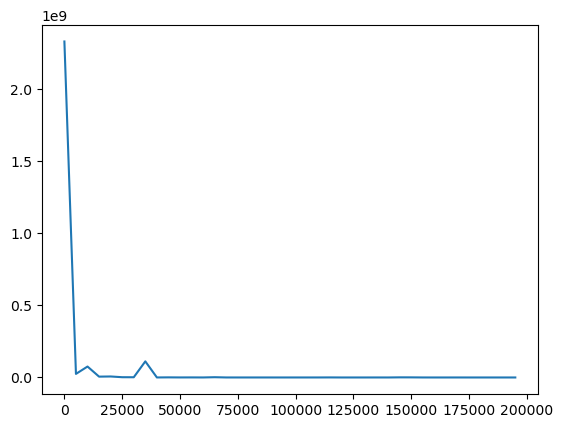

In [98]:
history = np.array(history)
plt.plot(history[:, 0], history[:, 1])

##### Check model with ground truth (`hh`)

In [99]:
model(X[:5, :])

tensor([-171.3726,  327.1957, -301.1226, -701.2781,  -99.7632],
       grad_fn=<ViewBackward0>)

In [100]:
hh(X[:5, :])

tensor([-265.7856, -406.0621, -242.2627, -664.9625, -205.6898],
       dtype=torch.float64)

##### Check autodiff with ground truth (`ddh`)

In [101]:
dhh(X[:5, :])

array([[ 1.3764988e+01,  1.6921589e+01,  9.9999997e-05,  1.1816174e+02],
       [-1.1958655e+01, -1.1714148e+02,  9.9999997e-05, -3.2154695e+03],
       [-1.1050865e+01, -1.1251266e+01,  9.9999997e-05, -6.1917881e+01],
       [-2.9777765e+01, -3.3650562e+01,  9.9999997e-05,  5.0248801e+02],
       [ 1.2787696e+01,  8.8519850e+00,  9.9999997e-05, -6.0127705e+01]],
      dtype=float32)

In [102]:
jac = torch_autodiff(model, X[:5, :]).sum(axis=1)
jac

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-3.2598e+01,  1.4704e+03, -2.5515e+03,  6.5574e+04],
        [-1.3564e+01, -1.6296e+01,  4.3613e+00, -7.7482e+01],
        [-4.3369e+01, -5.0168e+01,  6.9349e+01,  1.4399e+03],
        [-2.1006e+00,  1.1791e+00,  4.0246e+00, -2.6213e+01]])

In [103]:
np.square(jac - dhh(X[:5, :])).sum()

tensor(4.7419e+09)

**NOTE**: More training = autodiff more close (till a point)

**NOTE:** degree of deviation in derivative depends on number of layers and neurons and not largely on the loss values (i.e. low loss does not imply accurate derivative although it gives near accurate truth value). If the learned model is deep then derivative is better. 

In [104]:
#torch.save(model.state_dict(), './trained_obstacle_cbf/obs1data10000batch1000nn64x2')

## Compare visualisation

In [115]:
pp = np.arange(-20, 20, 0.5)
xx, yy = map(np.ravel, np.meshgrid(pp, pp))
vv = np.ones(xx.shape[0])# full velocity
grid = np.vstack([xx, yy, np.zeros(xx.shape[0]), vv * 0.01]).T
ytrue = hh(torch.from_numpy(grid.astype(np.float32)))
ypred = model(torch.from_numpy(grid.astype(np.float32))).detach()
grid2 = np.vstack([xx, yy, np.zeros(xx.shape[0]), vv * 0.5]).T
ytrue2 = hh(torch.from_numpy(grid2.astype(np.float32)))
ypred2 = model(torch.from_numpy(grid2.astype(np.float32))).detach()

In [1]:
plt.figure(figsize=(12, 10))
plt.subplot(221)
plt.scatter(xx, yy, c=-ytrue)
plt.colorbar()
plt.title('inital (v = 0)')
plt.subplot(222)
plt.scatter(xx, yy, c=-ypred)
plt.colorbar()
plt.title('learned (v = 0)')
plt.subplot(223)
plt.scatter(xx, yy, c=-ytrue2)
plt.colorbar()
plt.title('inital (v = 0)')
plt.subplot(224)
plt.scatter(xx, yy, c=(-ypred2) ** 0.5 - 15)
plt.title('learned (v = 10)')
plt.colorbar()

NameError: name 'plt' is not defined

# Load trained model

In [74]:
model = nn.Sequential(
    nn.Linear(4, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Flatten(0, 1)
)

In [77]:
model.load_state_dict(
    torch.load(
        './trained_obstacle_cbf/obs1data10000batch1000nn64x2', 
        weights_only=True)
    )

<All keys matched successfully>

In [78]:
process = lambda x: torch.tensor(x.reshape(1, -1)).float()

# Use CBF NN for QP

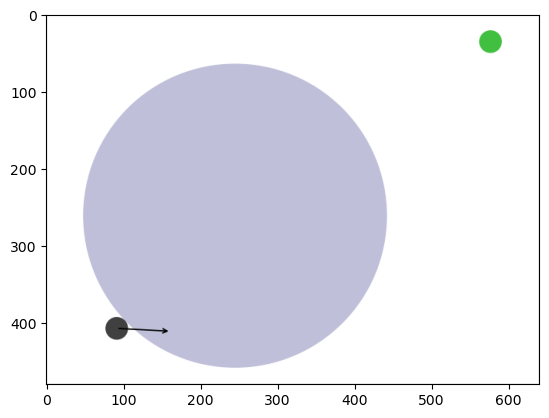

In [84]:
p_env.reset(seed=None) # 101, 111, 1111, 11111

xf = np.array([*p_env.world.landmarks[0].state.p_pos, 1e-6, 1e-6])
x0 = p_env.get_agent_states() # 0th agent
u_t = np.array([1e-6, 1e-6])
xs = x0.copy().reshape(1, -1)
us = u_t.copy().reshape(1, -1)

m = gp.Model("QP")
m.Params.DualReductions = 1
m.Params.FeasibilityTol = 1e-9
m.Params.LogToConsole = 0

uu = m.addMVar(shape=(2,), 
              lb=np.array([-max_accel, -max_steer]), 
              ub=np.array([max_accel, max_steer]), name='u')
# ud = m.addMVar(shape=(2,), lb=-GRB.INFINITY, name='ud')
slack = m.addVar(name='slack')

# control parameters
H = np.diag([1, 1])
Q = np.diag([10 / 20, 10 / 20, 0, 10 / 10])
R = np.diag([4 / 2, 0.1 / np.pi / 3]) #np.diag([0.001, 0.1])
c = 5e-1
p = 1e10

''' working control parameters 
# env seed = 7 num obstacles 5 with size 1.5
Q = np.diag([10 / 20, 10 / 20, 0, 1 / 10])
R = np.diag([4 / 2, 1 / np.pi / 3]) #np.diag([0.001, 0.1])
c = 1.25
p = 2e1

# env seed = 7 num obstacles 3 with size 2
Q = np.diag([10 / 20, 10 / 20, 0, 1 / 10])
R = np.diag([4 / 2, 1 / np.pi / 3]) #np.diag([0.001, 0.1])
c = 1
p = 1e2
# '''

costs = []
usafes = np.zeros(2) + 1e-5
slacks = []
debug = [{'h': [], 'dh0': [], 'dh1': [], 'Lf_h': [], 'Lg_h0': [], 'Lg_h1': []} for _ in range(2)]

for _ in p_env.agent_iter():
    
    observation, reward, termination, truncation, info = p_env.last()
    if termination or truncation:
        u_t = None
        break
    x_t = p_env.get_agent_states()

    A_t = np.array(A.subs(zip(states, x_t + 1e-6)
                    ).subs(zip(inputs, u_t + 1e-6)       
                    ).subs(L, wheelbase), dtype=np.float32) + 1e-6
    B_t = np.array(B.subs(zip(states, x_t + 1e-6)
                    ).subs(zip(inputs, u_t + 1e-6)
                    ).subs(L, wheelbase), dtype=np.float32) + 1e-6
    K, _, _ = lqr(A_t, B_t, Q, R)
    u_t = -K @ np.subtract(x_t, xf)
    u_t = np.clip(u_t, [-max_accel, -max_steer], 
                [max_accel, max_steer]).astype(np.float32)
    # Discrete LQR
    # Ad_t = np.array(Ad.subs(zip(states, x_t + 1e-6)
    #                 ).subs(zip(inputs, u_t + 1e-6)#[1e-6, 1e-6])     
    #                 ).subs(L, wheelbase), dtype=np.float32)
    # Bd_t = np.array(Bd.subs(zip(states, x_t + 1e-6)
    #                 ).subs(zip(inputs, u_t + 1e-6)#[1e-6, 1e-6])
    #                 ).subs(L, wheelbase), dtype=np.float32) 
    # Kd, _, _ = dlqr(Ad_t, Bd_t, Q, R)
    # u_t = -Kd @ np.subtract(x_t, xf)
    # u_t = np.clip(u_t, [-max_accel, -max_steer], 
    #             [max_accel, max_steer]).astype(np.float32)

    us = np.vstack([us, u_t])

    # CBF
    xx = process(x_t) 
    h = model(xx).detach().numpy()[0]
    dh = torch_autodiff(model, xx).sum(axis=1).numpy()
    Lf_h = (dh @ ff(x_t))[0] #
    Lg_h = dh @ gg(x_t)#
    debug[0]['h'].append(h)
    debug[0]['dh0'].append(dh[0, 0])
    debug[0]['dh1'].append(dh[0, 1])
    debug[0]['Lf_h'].append(Lf_h)
    debug[0]['Lg_h0'].append(Lg_h[0, 0])
    debug[0]['Lg_h1'].append(Lg_h[0, 1])
    
    h_true = hh(xx).item()
    dh_true = dhh(xx)
    Lf_h_true = (dh_true @ ff(x_t))[0] #
    Lg_h_true = dh_true @ gg(x_t)#
    debug[1]['h'].append(h_true)
    debug[1]['dh0'].append(dh_true[0, 0])
    debug[1]['dh1'].append(dh_true[0, 1])
    debug[1]['Lf_h'].append(Lf_h_true)
    debug[1]['Lg_h0'].append(Lg_h_true[0, 0])
    debug[1]['Lg_h1'].append(Lg_h_true[0, 1])
    

    m.addConstr(Lf_h + Lg_h @ uu <= -c * h + slack, 
                name='cbf_' + str(i))
    
    # m.addConstr(ud == uu - u_t, name='u_diff')
    obj = sum((uu - u_t) * (uu - u_t))
    # obj = (uu - u_t) @ H @ (uu - u_t)
    obj2 = p * slack
    m.setObjective(0.5 * obj + obj2, GRB.MINIMIZE)
    m.optimize()
    
    # with open('debug_cbf_gb.txt', 'a') as f:
    #     for const in m.getConstrs():
    #         f.write(f"{const.ConstrName} {const.rhs}\n")
    #     f.write(f"x(t) = {x_t}\nu(t) = {u_t}\n\n")

    if m.status == GRB.INFEASIBLE:
        plt.gca().clear()
        plt.imshow(p_env.render())
        # plt.xticks([]); plt.yticks([])
        display(plt.gcf())
        # clear_output(wait=True)
        print('ERROR: No feasible solution found!')
        
        break
    
    costs.append(m.getObjective().getValue())
    u_safe = [m.getVarByName(f"u[{i}]").X for i in range(2)]
    u_t = np.array(u_safe, dtype=np.float32)
    try: slacks.append(m.getVarByName(f"slack").X)
    except: pass  
    m.remove(m.getConstrs())

    p_env.step(u_t)

    xs = np.vstack([xs, x_t])
    usafes = np.vstack([usafes, u_t])
    
    plt.gca().clear()
    plt.imshow(p_env.render())
    # plt.xticks([]); plt.yticks([])
    display(plt.gcf())
    clear_output(wait=True)

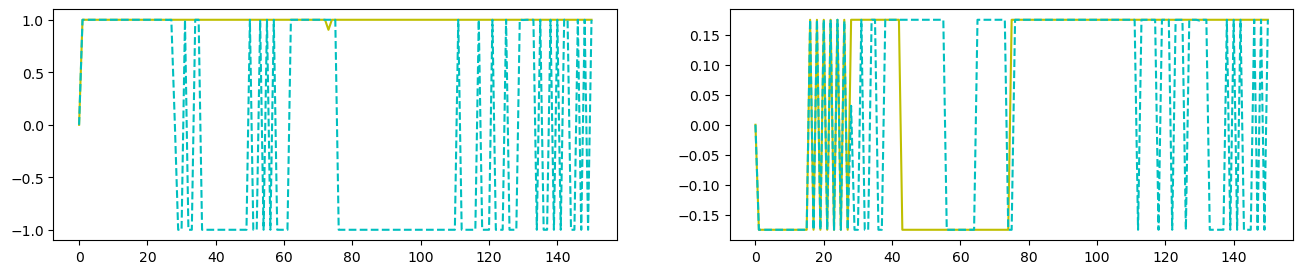

In [86]:
plt.figure(figsize=(16, 3))
plt.subplot(121)
plt.plot(us[:, 0], 'y')
plt.plot(usafes[:, 0], '--c')
plt.subplot(122)
plt.plot(us[:, 1], 'y')
plt.plot(usafes[:, 1], '--c')

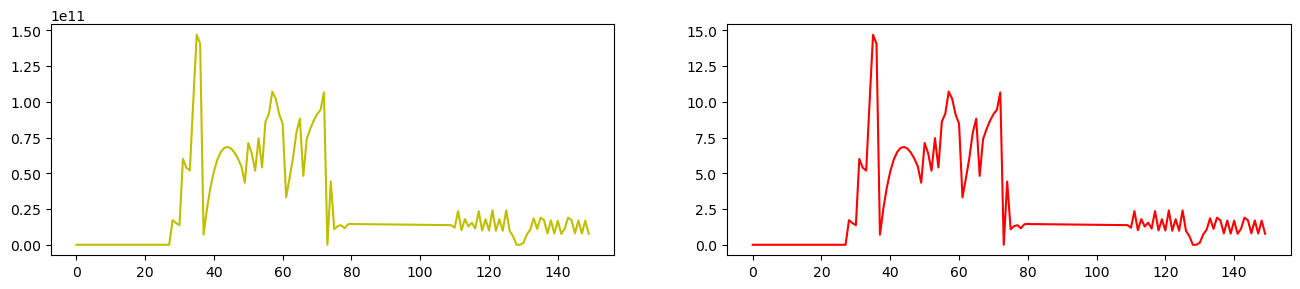

In [87]:
plt.figure(figsize=(16, 3))
plt.subplot(121)
plt.plot(costs, 'y')
plt.subplot(122)
plt.plot(slacks, 'r')

**debugging graphs**

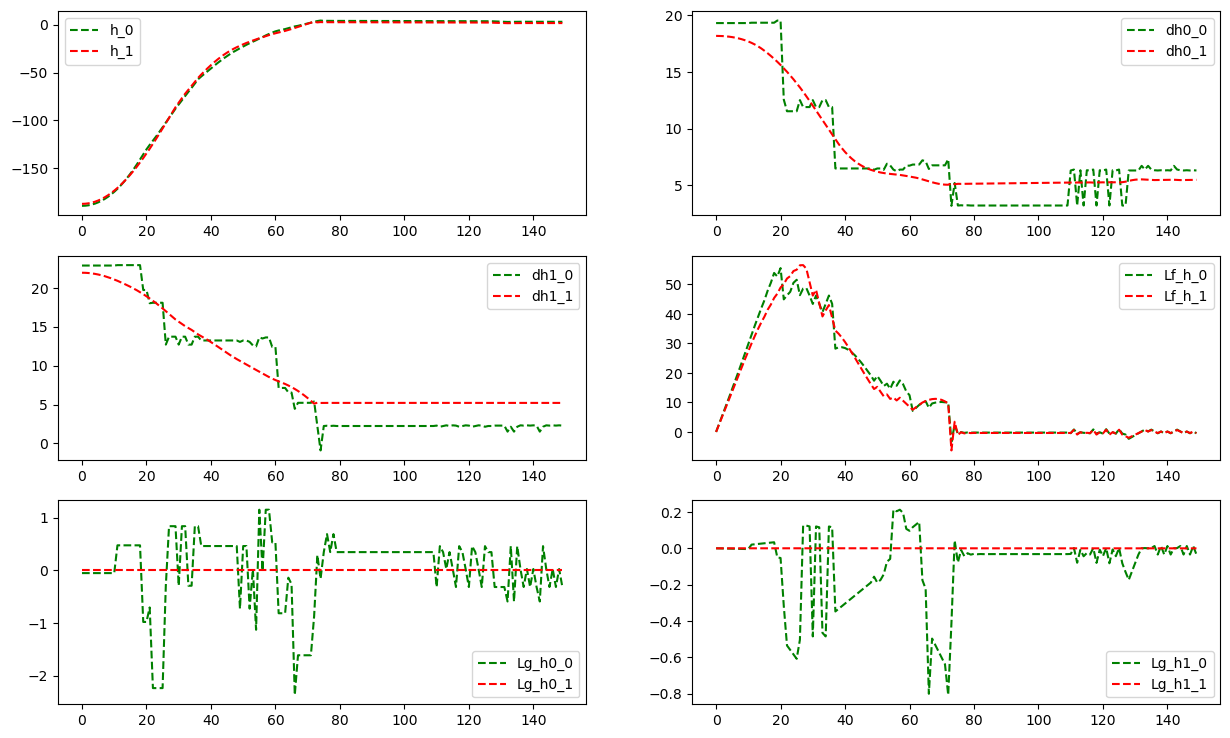

In [88]:
plt.figure(figsize=(15, 9))
plt.subplot(321)
for i in range(len(debug)):
    plt.plot(debug[i]['h'], '--' + 'grbmcyk'[i], label='h_' + str(i))
    plt.legend()
plt.subplot(322)
for i in range(len(debug)):
    plt.plot(debug[i]['dh0'], '--' + 'grbmcyk'[i], label='dh0_' + str(i))
    plt.legend()
plt.subplot(323)
for i in range(len(debug)):
    plt.plot(debug[i]['dh1'], '--' + 'grbmcyk'[i], label='dh1_' + str(i))
    plt.legend()
plt.subplot(324)
for i in range(len(debug)):
    plt.plot(debug[i]['Lf_h'], '--' + 'grbmcyk'[i], label='Lf_h_' + str(i))
    plt.legend()
plt.subplot(325)
for i in range(len(debug)):
    plt.plot(debug[i]['Lg_h0'], '--' + 'grbmcyk'[i], label='Lg_h0_' + str(i))
    plt.legend()
plt.subplot(326)
for i in range(len(debug)):
    plt.plot(debug[i]['Lg_h1'], '--' + 'grbmcyk'[i], label='Lg_h1_' + str(i))
    plt.legend()

In [90]:
td = torch.rand((2, 4))
td

tensor([[0.2742, 0.3986, 0.8643, 0.3206],
        [0.1407, 0.7205, 0.3662, 0.5788]])

In [92]:
jact = torch_autodiff(model, td).sum(axis=1)

tensor([[-1.5678,  1.3299, -0.1221,  0.8547],
        [ 1.2013,  1.1950, -0.0724,  0.6083]])

In [94]:
dhh(td) - jact

NameError: name 'jact' is not defined

### Compare control with Untrained NN

In [206]:
model = nn.Sequential(
    nn.Linear(4, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Flatten(0, 1)
)

In [207]:
summary(model, (1, 4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]             320
              ReLU-2                [-1, 1, 64]               0
            Linear-3                [-1, 1, 64]           4,160
              ReLU-4                [-1, 1, 64]               0
            Linear-5                 [-1, 1, 1]              65
           Flatten-6                    [-1, 1]               0
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


# Learn CBF NN (from Loss function)

**Dataset**

In [207]:
N = 10_000 # total number of samples
np.random.seed(11)
samples = np.random.uniform(
    low=(-20, -20, -np.pi, -5), 
    high=(20, 20, np.pi, 5),  
    size=(N, 4)).astype(np.float32)

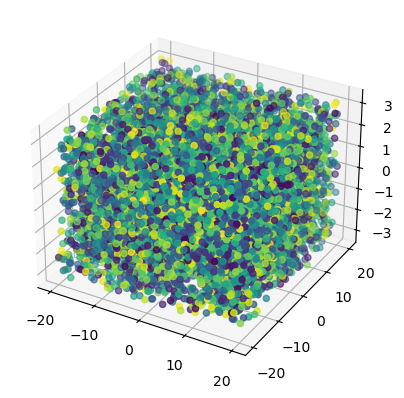

In [204]:
ax = plt.axes(projection='3d')
ax.scatter3D(samples[:, 0], samples[:, 1], samples[:, 2], c=samples[:, 3])

**Model**

In [328]:
model = nn.Sequential(
    nn.Linear(4, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Flatten(0, 1)
)

In [329]:
summary(model, (5000, 4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 5000, 64]             320
              ReLU-2             [-1, 5000, 64]               0
            Linear-3             [-1, 5000, 64]           4,160
              ReLU-4             [-1, 5000, 64]               0
            Linear-5              [-1, 5000, 1]              65
           Flatten-6                    [-1, 1]               0
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.08
Forward/backward pass size (MB): 9.80
Params size (MB): 0.02
Estimated Total Size (MB): 9.90
----------------------------------------------------------------


**Training (no labels)**

In [330]:
X = torch.from_numpy(samples)

#### Custom Loss
>that encodes properties of control-barrier function

Calculating derivative term (easy to hard)
* `difference-limit formula` on dataset of trajectories (from LQR)
* `time derivative` through jacobian dh @ f(x, u) where u from LQR
* same as above but `feasibility slack` in third term from CBF-QP (after LQR)

In [331]:
class CBFloss(nn.Module):
    def __init__(self, A, B, h, model):
        super(CBFloss, self).__init__()
        self.A = A
        self.B = B
        self.h = h
        self.model = model
        self.relu = nn.ReLU()
        self.dh = lambda X: torch_autodiff(model, X).sum(axis=1)

        # Solver
        self.m = gp.Model("QP")
        self.m.Params.DualReductions = 0
        self.m.Params.LogToConsole = 0
        self.uu = self.m.addMVar(shape=(2,), 
                    lb=np.array([-max_accel, -max_steer]), 
                    ub=np.array([max_accel, max_steer]), name='u')
        self.slack = self.m.addVar(name='slack')
        
    def forward(self, X):
        n_total = X.shape[0]
        safe = (self.h(X) >= 0).float()
        n_safe = safe.sum()
        unsafe = (self.h(X) < 0).float()
        n_unsafe = safe.sum()
        pred = self.model(X)
        output = self._calc_cbf_qp(X)
        return (self.relu(-pred) * safe).sum() / n_safe \
                + (self.relu(pred) * unsafe).sum() / n_unsafe \
                + self.relu(output).sum() / n_total

    def _get_refs(self, X, d=5):
        X_ref = X.detach().clone()
        X_ref[:, 0] += d * np.cos(X_ref[:, 2])
        X_ref[:, 0] += d * np.sin(X_ref[:, 2])
        return X_ref
    
    def _lqr_inputs(self, X, X_refs):
        global max_accel, max_steer, wheelbase
        Q = np.diag([10 / 20, 10 / 20, 0, 1 / 10])
        R = np.diag([4 / 2, 1 / np.pi / 3]) #np.diag([0.001, 0.1])
        U0s = []
        for xt, xf in zip(X, X_refs):
            Ad_t = np.array(self.A.subs(zip(states, xt + 1e-6)
                        ).subs(zip(inputs, [1e-6, 1e-6])       
                        ).subs(L, wheelbase), dtype=np.float32)
            Bd_t = np.array(Bd.subs(zip(states, xt + 1e-6)
                            ).subs(zip(inputs, [1e-6, 1e-6])
                            ).subs(L, wheelbase), dtype=np.float32) 
            Kd, _, _ = dlqr(Ad_t, Bd_t, Q, R)
            Kd = torch.tensor(Kd).float()
            u_t = -Kd @ torch.subtract(xt, xf)
            u_t = torch.clip(u_t, 
                        torch.tensor([-max_accel, -max_steer]), 
                        torch.tensor([max_accel, max_steer]))
            U0s.append(u_t)
        return U0s
            
    def _calc_cbf_qp(self, X, c=1.25, p=2e1):
        X_refs = self._get_refs(X)
        U0s = self._lqr_inputs(X, X_refs)
        dHs = self.dh(X)
        slacks = []
        for u0, xt, dh in zip(U0s, X, dHs):
            Ad_t = np.array(self.A.subs(zip(states, xt + 1e-6)
                        ).subs(zip(inputs, [1e-6, 1e-6])       
                        ).subs(L, wheelbase), dtype=np.float32)
            Bd_t = np.array(Bd.subs(zip(states, xt + 1e-6)
                            ).subs(zip(inputs, [1e-6, 1e-6])
                            ).subs(L, wheelbase), dtype=np.float32) 
            Lf_h = (dh @ Ad_t @ xt).numpy()
            Lg_h = (dh @ Bd_t).numpy()
            self.m.addConstr(Lf_h + Lg_h @ self.uu + self.slack >= -c * h, 
                            name='cbf_' + str(i))
            obj = sum((self.uu - u0.numpy()) * (self.uu - u0.numpy()))
            obj2 = p * self.slack
            self.m.setObjective(0.5 * obj + obj2, GRB.MINIMIZE)
            self.m.optimize()
            slacks.append(self.m.getVarByName(f"slack").X)
            self.m.remove(self.m.getConstrs())
        return torch.tensor(slacks).float()

In [332]:
loss_fn = CBFloss(Ad, Bd, hh, model)

Set parameter DualReductions to value 0


In [333]:
batch_size = 1000
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

**mini-batch gradient decent**

In [343]:
history = []
for t in range(500):
    if batch_size is not None:
        idx = np.random.choice(np.arange(N), batch_size)
        x_batch = X[idx, :]
    else: x_batch = X
    loss = loss_fn(x_batch)
    if t % 5 == 0:
        print(f"\t {t} (x {len(x_batch)}) -> {loss.item():.8f}", end='\r')
        history.append([t, loss.item()])

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

KeyboardInterrupt: 

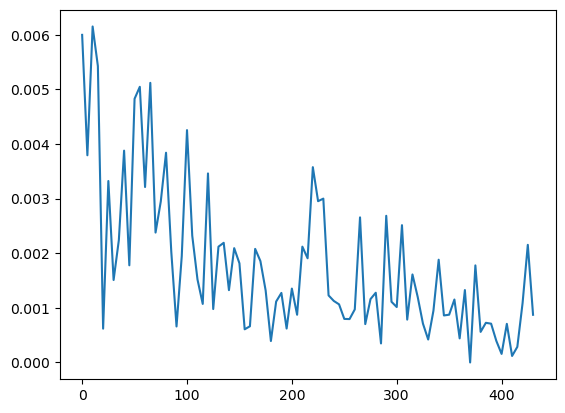

In [344]:
history = np.array(history)
plt.plot(history[:, 0], history[:, 1])

##### Check model with ground truth (`hh`)

In [345]:
model(process(x0))

tensor([0.0741], grad_fn=<ViewBackward0>)

##### Check autodiff with ground truth (`ddh`)

In [346]:
jac = torch_autodiff(model, process(x0)).sum(axis=1)
jac

tensor([[ 0.0144, -0.0051,  0.0255, -0.0139]])

In [347]:
torch.save(model.state_dict(), 'CBF_NN_chuchu-fan')

## Compare visualisation

In [348]:
pp = np.arange(-20, 20, 0.5)
xx, yy = map(np.ravel, np.meshgrid(pp, pp))
vv = np.ones(xx.shape[0])# full velocity
grid = np.vstack([xx, yy, np.zeros(xx.shape[0]), vv * 0]).T
ytrue = hh(torch.from_numpy(grid.astype(np.float32)))
ypred = model(torch.from_numpy(grid.astype(np.float32))).detach()
grid2 = np.vstack([xx, yy, np.zeros(xx.shape[0]), vv * 10]).T
ytrue2 = hh(torch.from_numpy(grid2.astype(np.float32)))
ypred2 = model(torch.from_numpy(grid2.astype(np.float32))).detach()

Text(0.5, 1.0, 'learned-via-NN (v = 10)')

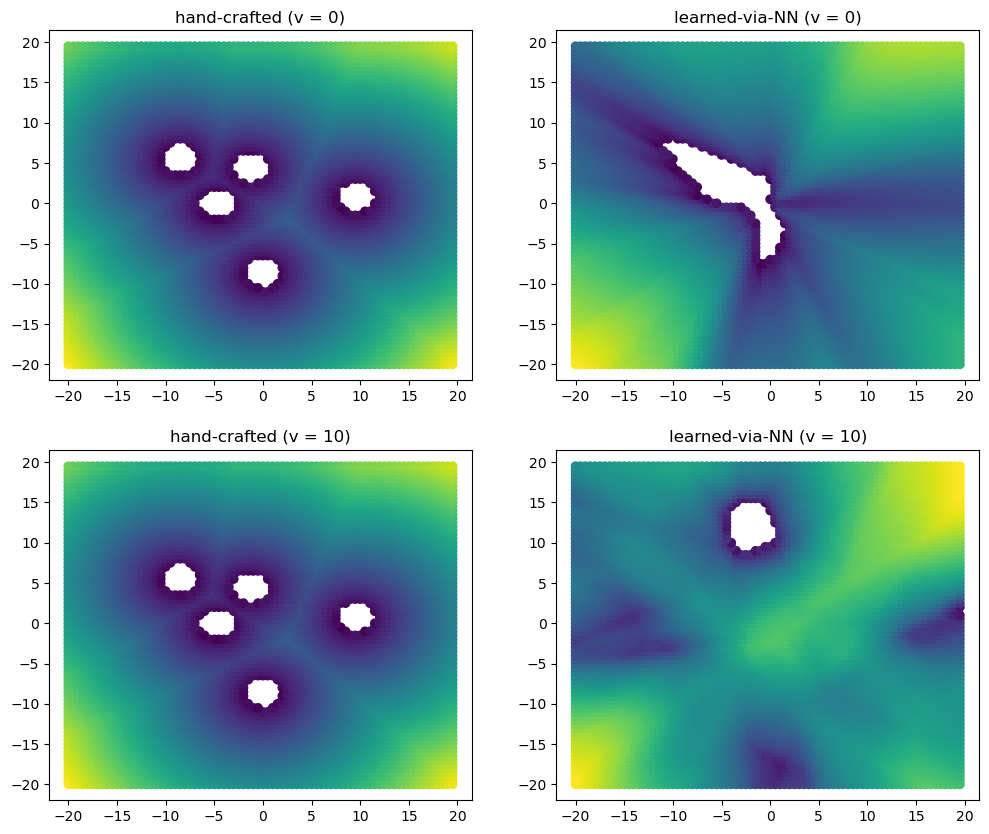

In [349]:
plt.figure(figsize=(12, 10))
plt.subplot(221)
plt.scatter(xx, yy, c=ytrue ** 0.5)
plt.title('hand-crafted (v = 0)')
plt.subplot(222)
plt.scatter(xx, yy, c=ypred ** 0.5)
plt.title('learned-via-NN (v = 0)')
plt.subplot(223)
plt.scatter(xx, yy, c=ytrue2 ** 0.5)
plt.title('hand-crafted (v = 10)')
plt.subplot(224)
plt.scatter(xx, yy, c=ypred2 ** 0.5)
plt.title('learned-via-NN (v = 10)')

# Env instance (with `less` obstacles)

In [447]:
p_env.close()

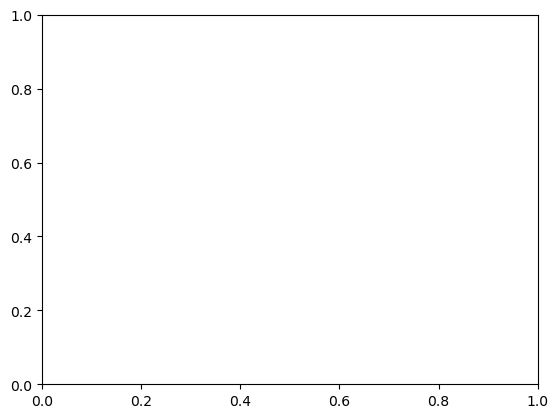

In [47]:
from pettingzoo.custom import simple_reach_v3

p_env = simple_reach_v3.env(
            seed=7,
            render_mode="rgb_array",
            num_obstacles=1,
            obstacle_size=2,
            continuous_actions=True,
            max_cycles=200)

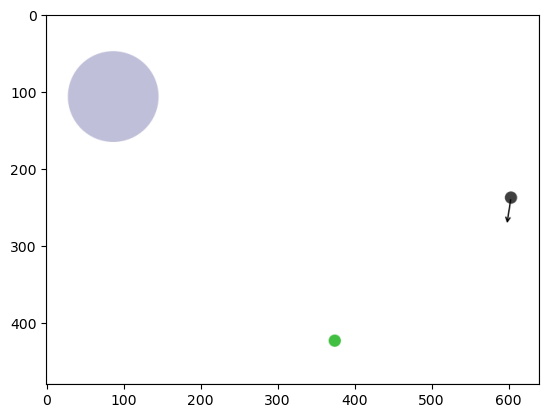

In [65]:
p_env.reset()
plt.imshow(p_env.render())
# plt.xticks([]); plt.yticks([])

In [66]:
np.degrees(p_env.world.agents[0].state.p_yaw)

array([-43.31795526])

In [65]:
p_env.world.agents[0].state.p_pos

array([-2.38141934, -9.05521519])

# Learn CBF NN (from Loss function)

**Dataset**

In [453]:
N = 10_000 # total number of samples
np.random.seed(11)
samples = np.random.uniform(
    low=(-20, -20, -np.pi, -5), 
    high=(20, 20, np.pi, 5),  
    size=(N, 4)).astype(np.float32)

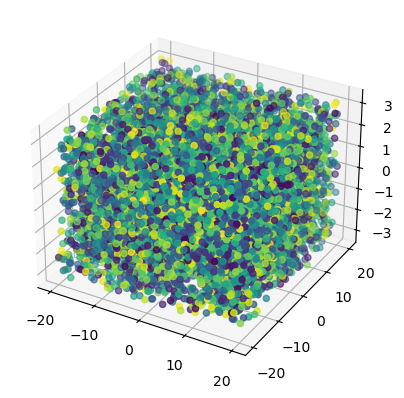

In [454]:
ax = plt.axes(projection='3d')
ax.scatter3D(samples[:, 0], samples[:, 1], samples[:, 2], c=samples[:, 3])

**Model**

In [455]:
model = nn.Sequential(
    nn.Linear(4, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Flatten(0, 1)
)

In [456]:
summary(model, (5000, 4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 5000, 64]             320
              ReLU-2             [-1, 5000, 64]               0
            Linear-3             [-1, 5000, 64]           4,160
              ReLU-4             [-1, 5000, 64]               0
            Linear-5              [-1, 5000, 1]              65
           Flatten-6                    [-1, 1]               0
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.08
Forward/backward pass size (MB): 9.80
Params size (MB): 0.02
Estimated Total Size (MB): 9.90
----------------------------------------------------------------


**Training (no labels)**

In [457]:
X = torch.from_numpy(samples)

#### Custom Loss
>that encodes properties of control-barrier function

Calculating derivative term (easy to hard)
* `difference-limit formula` on dataset of trajectories (from LQR)
* `time derivative` through jacobian dh @ f(x, u) where u from LQR
* same as above but `feasibility slack` in third term from CBF-QP (after LQR)

In [463]:
class CBFloss(nn.Module):
    def __init__(self, A, B, h, model):
        super(CBFloss, self).__init__()
        self.A = A
        self.B = B
        self.h = h
        self.model = model
        self.relu = nn.ReLU()
        self.dh = lambda X: torch_autodiff(model, X).sum(axis=1)

        # Solver
        self.m = gp.Model("QP")
        self.m.Params.DualReductions = 0
        self.m.Params.LogToConsole = 0
        self.uu = self.m.addMVar(shape=(2,), 
                    lb=np.array([-max_accel, -max_steer]), 
                    ub=np.array([max_accel, max_steer]), name='u')
        self.slack = self.m.addVar(name='slack')
        
    def forward(self, X):
        n_total = X.shape[0]
        safe = (self.h(X) >= 0).float()
        n_safe = safe.sum()
        unsafe = (self.h(X) < 0).float()
        n_unsafe = safe.sum()
        pred = self.model(X)
        output = self._calc_cbf_qp(X)
        return (self.relu(-pred) * safe).sum() / n_safe \
                + (self.relu(pred) * unsafe).sum() / n_unsafe \
                + self.relu(output).sum() / n_total

    def _get_refs(self, X, d=5):
        X_ref = X.detach().clone()
        X_ref[:, 0] += d * np.cos(X_ref[:, 2])
        X_ref[:, 0] += d * np.sin(X_ref[:, 2])
        return X_ref
    
    def _lqr_inputs(self, X, X_refs):
        global max_accel, max_steer, wheelbase
        Q = np.diag([10 / 20, 10 / 20, 0, 1 / 10])
        R = np.diag([4 / 2, 1 / np.pi / 3]) #np.diag([0.001, 0.1])
        U0s = []
        for xt, xf in zip(X, X_refs):
            Ad_t = np.array(self.A.subs(zip(states, xt + 1e-6)
                        ).subs(zip(inputs, [1e-6, 1e-6])       
                        ).subs(L, wheelbase), dtype=np.float32)
            Bd_t = np.array(Bd.subs(zip(states, xt + 1e-6)
                            ).subs(zip(inputs, [1e-6, 1e-6])
                            ).subs(L, wheelbase), dtype=np.float32) 
            Kd, _, _ = dlqr(Ad_t, Bd_t, Q, R)
            Kd = torch.tensor(Kd).float()
            u_t = -Kd @ torch.subtract(xt, xf)
            u_t = torch.clip(u_t, 
                        torch.tensor([-max_accel, -max_steer]), 
                        torch.tensor([max_accel, max_steer]))
            U0s.append(u_t)
        return U0s
            
    def _calc_cbf_qp(self, X, c=1.25, p=2e1):
        X_refs = self._get_refs(X)
        U0s = self._lqr_inputs(X, X_refs)
        dHs = self.dh(X)
        slacks = []
        for u0, xt, dh in zip(U0s, X, dHs):
            Ad_t = np.array(self.A.subs(zip(states, xt + 1e-6)
                        ).subs(zip(inputs, [1e-6, 1e-6])       
                        ).subs(L, wheelbase), dtype=np.float32)
            Bd_t = np.array(Bd.subs(zip(states, xt + 1e-6)
                            ).subs(zip(inputs, [1e-6, 1e-6])
                            ).subs(L, wheelbase), dtype=np.float32) 
            Lf_h = (dh @ Ad_t @ xt).numpy()
            Lg_h = (dh @ Bd_t).numpy()
            self.m.addConstr(Lf_h + Lg_h @ self.uu + self.slack >= -c * h, 
                            name='cbf_' + str(i))
            obj = sum((self.uu - u0.numpy()) * (self.uu - u0.numpy()))
            obj2 = p * self.slack
            self.m.setObjective(0.5 * obj + obj2, GRB.MINIMIZE)
            self.m.optimize()
            slacks.append(self.m.getVarByName(f"slack").X)
            self.m.remove(self.m.getConstrs())
        return torch.tensor(slacks).float()

In [464]:
loss_fn = CBFloss(Ad, Bd, hh, model)

Set parameter DualReductions to value 0


In [465]:
batch_size = 200
learning_rate = 3e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

**mini-batch gradient decent**

In [466]:
history = []
for t in range(500):
    if batch_size is not None:
        idx = np.random.choice(np.arange(N), batch_size)
        x_batch = X[idx, :]
    else: x_batch = X
    loss = loss_fn(x_batch)
    if t % 5 == 0:
        print(f"\t {t} (x {len(x_batch)}) -> {loss.item():.8f}", end='\r')
        history.append([t, loss.item()])

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

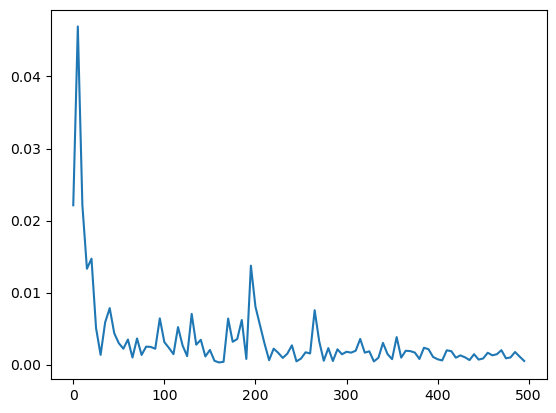

In [468]:
history = np.array(history)
plt.plot(history[:, 0], history[:, 1])

##### Check model with ground truth (`hh`)

In [469]:
model(process(x0))

tensor([0.0345], grad_fn=<ViewBackward0>)

##### Check autodiff with ground truth (`ddh`)

In [470]:
jac = torch_autodiff(model, process(x0)).sum(axis=1)
jac

tensor([[0.0073, 0.0214, 0.0134, 0.0027]])

In [472]:
torch.save(model.state_dict(), 'single-CBF_NN_chuchu-fan')

## Compare visualisation

In [473]:
pp = np.arange(-20, 20, 0.5)
xx, yy = map(np.ravel, np.meshgrid(pp, pp))
vv = np.ones(xx.shape[0])# full velocity
grid = np.vstack([xx, yy, np.zeros(xx.shape[0]), vv * 0]).T
ytrue = hh(torch.from_numpy(grid.astype(np.float32)))
ypred = model(torch.from_numpy(grid.astype(np.float32))).detach()
grid2 = np.vstack([xx, yy, np.zeros(xx.shape[0]), vv * 10]).T
ytrue2 = hh(torch.from_numpy(grid2.astype(np.float32)))
ypred2 = model(torch.from_numpy(grid2.astype(np.float32))).detach()

Text(0.5, 1.0, 'learned-via-NN (v = 10)')

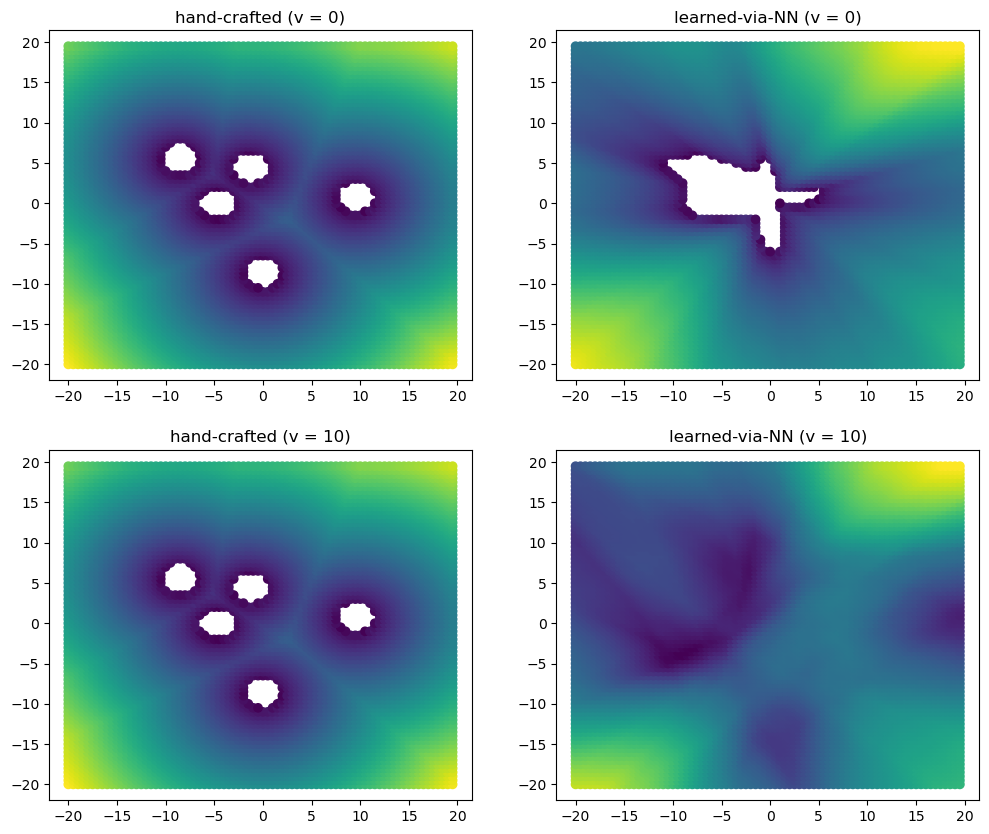

In [474]:
plt.figure(figsize=(12, 10))
plt.subplot(221)
plt.scatter(xx, yy, c=ytrue ** 0.5)
plt.title('hand-crafted (v = 0)')
plt.subplot(222)
plt.scatter(xx, yy, c=ypred ** 0.5)
plt.title('learned-via-NN (v = 0)')
plt.subplot(223)
plt.scatter(xx, yy, c=ytrue2 ** 0.5)
plt.title('hand-crafted (v = 10)')
plt.subplot(224)
plt.scatter(xx, yy, c=ypred2 ** 0.5)
plt.title('learned-via-NN (v = 10)')

# CBF-QP

KeyboardInterrupt: 

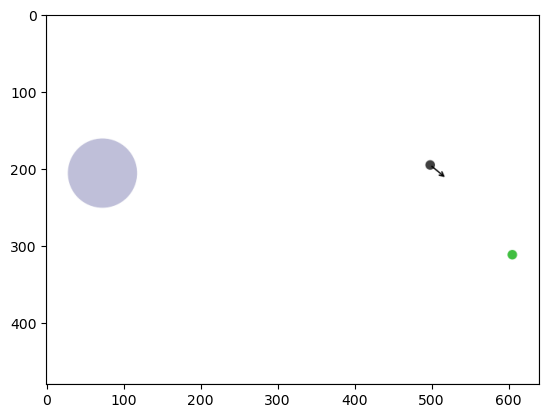

In [ ]:
p_env.reset(seed=None) # 101

xf = np.array([*p_env.world.landmarks[0].state.p_pos, 1e-6, 1e-6])
x0 = p_env.get_agent_states() # 0th agent
xs, us = x0.copy().reshape(1, -1), np.array([[1e-6, 1e-6]])

m = gp.Model("QP")
m.Params.DualReductions = 0
# m.Params.FeasibilityTol = 0.0000001
m.Params.LogToConsole = 0

uu = m.addMVar(shape=(2,), 
              lb=np.array([-max_accel, -max_steer]), 
              ub=np.array([max_accel, max_steer]), name='u')
# ud = m.addMVar(shape=(2,), lb=-GRB.INFINITY, name='ud')
slack = m.addVar(name='slack')

# control parameters
Q = np.diag([10 / 20, 10 / 20, 0, 1 / 10])
R = np.diag([4 / 2, 1 / np.pi / 3]) #np.diag([0.001, 0.1])
c = 1.25
p = 2e1

''' working control parameters 
# env seed = 7 num obstacles 5 with size 1.5
Q = np.diag([10 / 20, 10 / 20, 0, 1 / 10])
R = np.diag([4 / 2, 1 / np.pi / 3]) #np.diag([0.001, 0.1])
c = 1.25
p = 2e1

# env seed = 7 num obstacles 3 with size 2
Q = np.diag([10 / 20, 10 / 20, 0, 1 / 10])
R = np.diag([4 / 2, 1 / np.pi / 3]) #np.diag([0.001, 0.1])
c = 1
p = 1e2
# '''

costs = []
usafes = np.zeros(2) + 1e-5
slacks = []
debug = [{'h': [], 'dh0': [], 'dh1': [], 'Lf_h': [], 'Lg_h0': [], 'Lg_h1': []} 
            for _ in range(len(p_env.world.landmarks) - 1)]

for _ in p_env.agent_iter():
    
    observation, reward, termination, truncation, info = p_env.last()
    if termination or truncation:
        u_t = None
        break

    x_t = p_env.get_agent_states()
    Ad_t = np.array(Ad.subs(zip(states, x_t + 1e-6)
                    ).subs(zip(inputs, [1e-6, 1e-6])       
                    ).subs(L, wheelbase), dtype=np.float32)
    Bd_t = np.array(Bd.subs(zip(states, x_t + 1e-6)
                    ).subs(zip(inputs, [1e-6, 1e-6])
                    ).subs(L, wheelbase), dtype=np.float32) 
    # Ad_t = np.array(Ad.subs(zip(states, x_t + 1e-6)
    #                 ).subs(zip(inputs, u_t + 1e-6)       
    #                 ).subs(L, wheelbase), dtype=np.float32)
    # Bd_t = np.array(Bd.subs(zip(states, x_t + 1e-6)
    #                 ).subs(zip(inputs, u_t + 1e-6)
    #                 ).subs(L, wheelbase), dtype=np.float32) 

    # LQR
    Kd, _, _ = dlqr(Ad_t, Bd_t, Q, R)
    u_t = -Kd @ np.subtract(x_t, xf)
    u_t = np.clip(u_t, [-max_accel, -max_steer], 
                [max_accel, max_steer]).astype(np.float32)

    us = np.vstack([us, u_t])

    # CBF
    h_min = float('inf')
    for i, o in enumerate(p_env.world.landmarks[1:]):
        dist = np.sum(np.square(x_t[:2] - o.state.p_pos))
        h = dist - (o.size + wheelbase) ** 2 # + p_env.world.contact_margin)
        dh = 2 * np.array([*(x_t[:2] - o.state.p_pos), 1e-6, 1e-6])
        Lf_h = dh @ Ad_t @ x_t#  ff(x_t))[0] #
        Lg_h = dh @ Bd_t #  gg(x_t)#
       
        debug[i]['h'].append(h)
        debug[i]['dh0'].append(dh[0])
        debug[i]['dh1'].append(dh[1])
        debug[i]['Lf_h'].append(Lf_h)
        debug[i]['Lg_h0'].append(Lg_h[0])
        debug[i]['Lg_h1'].append(Lg_h[1])
        
        # with open('.txt', 'a') as f:
        #     # f.write(f"{debug[i]['Lf_h']} + {debug[i]['Lf_h']} * u0 + {debug[i]['Lf_g0']} * u1 >= - {c} * {h}")
        #     if i == 0:
        #         f.write('\n')
        #     f.write(f"{Lf_h:.3f} + {Lg_h[0]:.3f} * u0 + {Lg_h[1]:.3f} * u1 >= - {c} * {h:.3f}\n")
            
        m.addConstr(Lf_h + Lg_h @ uu + slack >= -c * h, 
                    name='cbf_' + str(i))
    
    # m.addConstr(ud == uu - u_t, name='u_diff')
    obj = sum((uu - u_t) * (uu - u_t))
    # obj = (uu - u_t) @ (uu - u_t)
    obj2 = p * slack
    m.setObjective(0.5 * obj + obj2, GRB.MINIMIZE)
    m.optimize()
    
    # with open('debug_cbf_gb.txt', 'a') as f:
    #     for const in m.getConstrs():
    #         f.write(f"{const.ConstrName} {const.rhs}\n")
    #     f.write(f"x(t) = {x_t}\nu(t) = {u_t}\n\n")

    if m.status == GRB.INFEASIBLE:
        plt.gca().clear()
        plt.imshow(p_env.render())
        # plt.xticks([]); plt.yticks([])
        display(plt.gcf())
        # clear_output(wait=True)
        print('ERROR: No feasible solution found!')
        
        break
    
    costs.append(m.getObjective().getValue())
    u_safe = [m.getVarByName(f"u[{i}]").X for i in range(2)]
    u_t = np.array(u_safe, dtype=np.float32)
    try: slacks.append(m.getVarByName(f"slack").X)
    except: pass  
    m.remove(m.getConstrs())

    p_env.step(u_t)

    xs = np.vstack([xs, x_t])
    usafes = np.vstack([usafes, u_t])
    
    plt.gca().clear()
    plt.imshow(p_env.render())
    # plt.xticks([]); plt.yticks([])
    display(plt.gcf())
    clear_output(wait=True)

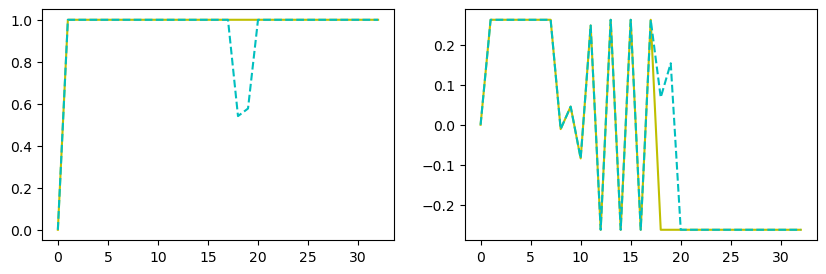

In [450]:
plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.plot(us[:, 0], 'y')
plt.plot(usafes[:, 0], '--c')
plt.subplot(122)
plt.plot(us[:, 1], 'y')
plt.plot(usafes[:, 1], '--c')

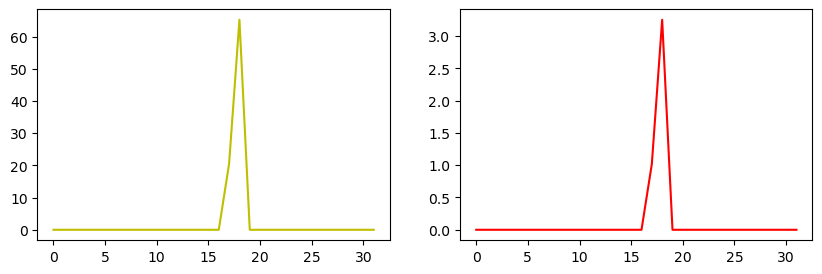

In [451]:
plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.plot(costs, 'y')
plt.subplot(122)
plt.plot(slacks, 'r')

**debugging graphs**

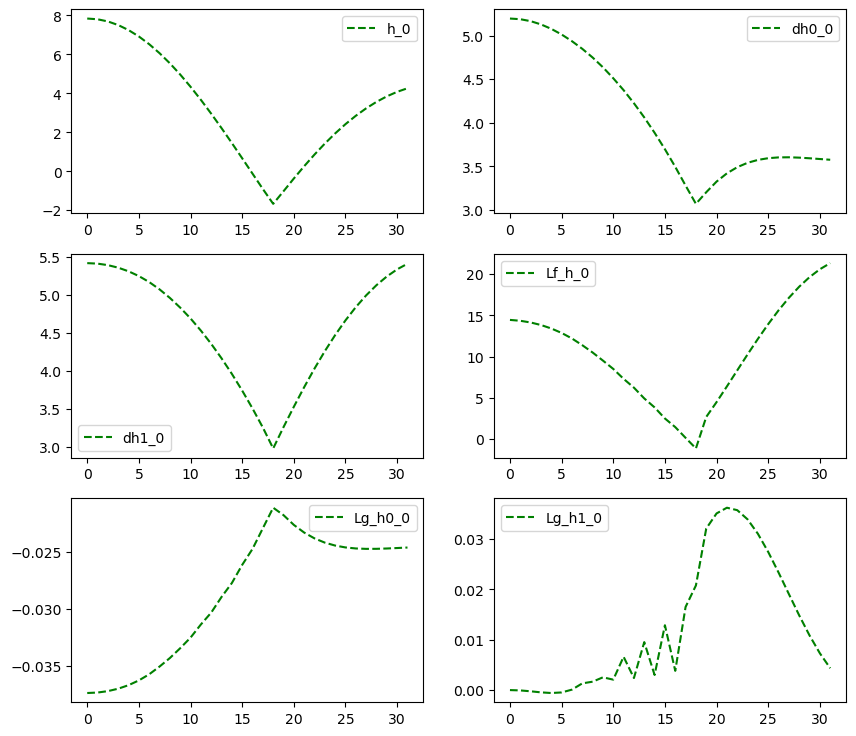

In [452]:
plt.figure(figsize=(10, 9))
plt.subplot(321)
for i in range(len(debug)):
    plt.plot(debug[i]['h'], '--' + 'grb'[i], label='h_' + str(i))
    plt.legend()
plt.subplot(322)
for i in range(len(debug)):
    plt.plot(debug[i]['dh0'], '--' + 'grb'[i], label='dh0_' + str(i))
    plt.legend()
plt.subplot(323)
for i in range(len(debug)):
    plt.plot(debug[i]['dh1'], '--' + 'grb'[i], label='dh1_' + str(i))
    plt.legend()
plt.subplot(324)
for i in range(len(debug)):
    plt.plot(debug[i]['Lf_h'], '--' + 'grb'[i], label='Lf_h_' + str(i))
    plt.legend()
plt.subplot(325)
for i in range(len(debug)):
    plt.plot(debug[i]['Lg_h0'], '--' + 'grb'[i], label='Lg_h0_' + str(i))
    plt.legend()
plt.subplot(326)
for i in range(len(debug)):
    plt.plot(debug[i]['Lg_h1'], '--' + 'grb'[i], label='Lg_h1_' + str(i))
    plt.legend()

In [ ]:
m.computeIIS()
for i in range(len(m.IISConstr)):
    if m.IISConstr[i]:
        print(m.getConstrs()[i], )

GurobiError: Cannot compute IIS on a feasible model

In [ ]:
print('all constraints')
for const in m.getConstrs():
    print(const.ConstrName, const.rhs)
    
m.getConstrByName('cbf_0').rhs

all constraints


AttributeError: 'NoneType' object has no attribute 'rhs'

## Learn the same CBF

In [ ]:
import torch
from torch import nn
from torchsummary import summary
from torch.autograd.functional import jacobian as torch_autodiff

import numpy as np
import matplotlib.pyplot as plt

**In env, modify**

> CBF nn agent
* action - value
* observation - state
> adversary agent
* action - input (small perturbations/full control)
* observation - state (with/without obstacle positions)

**design reward for both**
> use collision (terminate)



# CBF-QP (Test)
**using `cvxopt`**

In [ ]:
from cvxopt import matrix, solvers

solvers.options['show_progress'] = False 
solvers.options['maxiters'] = 1000 

KeyboardInterrupt: 

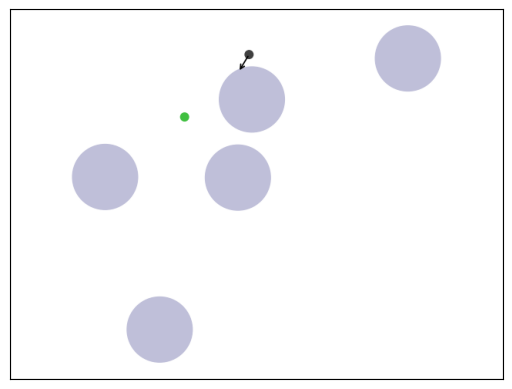

In [ ]:
p_env.reset(seed=1)

xf = np.array([*p_env.world.landmarks[0].state.p_pos, 1e-6, 1e-6])
x0 = p_env.get_agent_states() # 0th agent
xs, us = x0.copy().reshape(1, -1), np.array([[0.00001, 0.00001]])

Q = np.diag([10/ 100, 10 / 100, 0, 1 / 10])
R = np.diag([4 / 2, 0.25 / np.pi / 9]) #np.diag([0.001, 0.1])
# c = 5e0
# Q = np.diag([25/ 100, 25 / 100, 0, 1 / 10])
# R = np.diag([1 / 2, 0.25 / np.pi / 9]) #np.diag([0.001, 0.1])
p = 1e-6
c = 1e2

for _ in p_env.agent_iter():
    
    observation, reward, termination, truncation, info = p_env.last()
    if termination or truncation:
        u = None
        break
    else:
        x_t = p_env.get_agent_states()
        Ad_t = np.array(Ad.subs(zip(states, x_t + 1e-6)
                        ).subs(zip(inputs, [1e-6, 1e-6])       
                        ).subs(L, wheelbase), dtype=np.float32)
        Bd_t = np.array(Bd.subs(zip(states, x_t + 1e-6)
                        ).subs(zip(inputs, [1e-6, 1e-6])
                        ).subs(L, wheelbase), dtype=np.float32) 

        # LQR
        Kd, _, _ = dlqr(Ad_t, Bd_t, Q, R)
        u_t = -Kd @ np.subtract(x_t, xf)
        u_t = np.clip(u_t, [-max_accel, -max_steer], 
                    [max_accel, max_steer]).astype(np.float32)


        J = 2 * matrix(np.diag([1.0, 1.0, p]))
        f = matrix([-2.0 * u_t[0], -2.0 * u_t[1], p])

        # CBF
        h_list, dh_list = [], []
        for o in p_env.world.landmarks[1:]:
            dist = np.linalg.norm(x_t[:2] - o.state.p_pos)
            h_list.append(dist - (o.size + wheelbase))
            dh_list.append(np.array([2 * x_t[0], 2 * x_t[1], 0, 0]))

        # Actuation constraints
        G = [[0.0, 0.0, -1.0],
            [1.0, 0.0, 0.0],
            [-1.0, 0.0, 0.0],
            [0.0, 1.0, 0.0],
            [0.0, -1.0, 0.0]]
        b = [0.0, max_accel, max_accel, max_steer, max_steer]

        # CBF constraints
        for h, dh in zip(h_list, dh_list):
            
            Lf_h = dh @ Ad_t @ x_t
            Lg_h = dh @ Bd_t
            
            G.append([-Lg_h[0], -Lg_h[1], 0.0])
            b.append(c * h + Lf_h)

        # QP
        # try:
        G = matrix(np.array(G), tc='d')
        b = matrix(np.array(b), tc='d')
        sol = solvers.qp(J, f, G, b)
        if sol['status'] != 'optimal':
            raise ValueError('unable to solve')
        u_safe = np.array(sol['x'][:-1], dtype=np.float32).ravel()
        # except Exception as e:
        #      print(e, '\nJ = ', J, '\nf = ', f, '\nG = ', G, '\nb = ', b)
        #      print('Ad(t) = ', Ad_t, '\nBd(t) = ', Bd_t, '\nx(t) = ', x_t)
        #      break

    p_env.step(u_safe)

    xs = np.vstack([xs, x_t])
    us = np.vstack([us, u_safe])
    
    plt.gca().clear()
    plt.imshow(p_env.render())
    plt.xticks([])
    plt.yticks([])
    display(plt.gcf())
    clear_output(wait=True)

```
unable to solve 
J =  [ 2.00e+00  0.00e+00  0.00e+00]
[ 0.00e+00  2.00e+00  0.00e+00]
[ 0.00e+00  0.00e+00  2.00e-01]
 
f =  [ 2.27e-01]
[-3.49e-01]
[ 1.00e-01]
 
G =  [ 0.00e+00  0.00e+00 -1.00e+00]
[ 1.00e+00  0.00e+00  0.00e+00]
[-1.00e+00  0.00e+00  0.00e+00]
[ 0.00e+00  1.00e+00  0.00e+00]
[ 0.00e+00 -1.00e+00  0.00e+00]
[-1.63e-01  5.59e-04  0.00e+00]
 
b =  [ 0.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.75e-01]
[ 1.75e-01]
[ 5.63e+02]

Ad(t) =  [[ 1.000000e+00  0.000000e+00  9.311643e-03  6.974984e-02]
 [ 0.000000e+00  1.000000e+00 -9.063604e-03  7.165863e-02]
 [ 0.000000e+00  0.000000e+00  1.000000e+00  2.000000e-06]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]] 
Bd(t) =  [[ 3.4874915e-03 -1.2099964e-04]
 [ 3.5829321e-03  1.1777651e-04]
 [ 1.0000000e-07 -2.5988892e-02]
 [ 1.0000000e-01  0.0000000e+00]] 
x(t) =  [12.57261802 10.54152115  0.7988859  -0.12995446]
```

# MARL

In [11]:
from pettingzoo.mpe import simple_v3


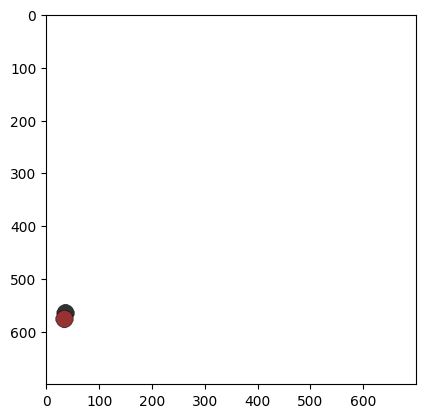

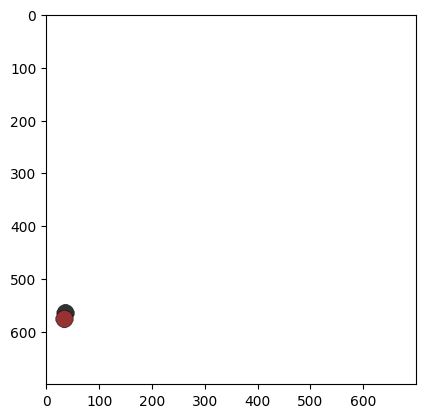

In [82]:
T = 15
p_env = simple_v3.env(render_mode="rgb_array",
                    continuous_actions=True,
                    max_cycles=T * 10)
p_env.reset()

xf = np.array([*p_env.world.landmarks[0].state.p_pos, 1e-6, 1e-5])
agent = p_env.world.agents[0]
x0 = np.concatenate([agent.state.p_pos, 
            agent.state.p_yaw, 
            [np.linalg.norm(agent.state.p_vel)]])
xs, us = x0.copy().reshape(1, -1), np.array([[0.00001, 0.00001]])
xts = x0.copy().reshape(1, -1)
actions = np.array([[0.00001, 0.00001]])

Q = np.diag([2.5, 2.5, 0, 2.25])
R = np.diag([1.25, 0.25]) #np.diag([0.001, 0.1])

for _ in np.arange(0, T, dt)[:-1]:

    # Ad_t = np.array(Ad.subs(zip(states, xs[-1] + 1e-5)
    #                 ).subs(zip(inputs, us[-1] + 1e-5)       
    #                 ).subs(L, wheelbase), dtype=np.float32)
    # Bd_t = np.array(Bd.subs(zip(states, xs[-1] + 1e-5)
    #                 ).subs(zip(inputs, us[-1] + 1e-5)
    #                 ).subs(L, wheelbase), dtype=np.float32)  
    Ad_t = np.array(Ad.subs(zip(states, xs[-1] + 1e-5)
                    ).subs(zip(inputs, [1e-5, 1e-5])       
                    ).subs(L, wheelbase), dtype=np.float32)
    Bd_t = np.array(Bd.subs(zip(states, xs[-1] + 1e-5)
                    ).subs(zip(inputs, [1e-5, 1e-5])
                    ).subs(L, wheelbase), dtype=np.float32) 

    Kd, _, _ = dlqr(Ad_t, Bd_t, Q, R)
    u = -Kd @ np.subtract(xs[-1], xf)
    u = np.clip(u, [-max_accel, -max_steer], 
                [max_accel, max_steer])

    us = np.vstack([us, u])
    # xs = np.vstack([xs, [xs[-1][0] + xs[-1][3] * np.cos(xs[-1][2]) * dt,
    #                      xs[-1][1] + xs[-1][3] * np.sin(xs[-1][2]) * dt,
    #                      xs[-1][2] + xs[-1][3] * np.tan(u[1] / wheelbase) * dt,
    #                      xs[-1][3] + u[0] * dt]])
    xs = np.vstack([xs, odeint(vehicle_update, xs[-1], [0, dt], 
                    args=(us[-1],), tfirst=True)[-1]])

for _ in p_env.agent_iter():
    observation, reward, termination, truncation, info = p_env.last()
    if termination or truncation:
        action = None
        break
    else:
        agent = p_env.world.agents[0]
        xt = np.concatenate([agent.state.p_pos, 
            agent.state.p_yaw, 
            agent.state.p_vel])
        Ad_t = np.array(Ad.subs(zip(states, xt + 1e-5)
                        ).subs(zip(inputs, [1e-5, 1e-5])       
                        ).subs(L, wheelbase), dtype=np.float32)
        Bd_t = np.array(Bd.subs(zip(states, xt + 1e-5)
                        ).subs(zip(inputs, [1e-5, 1e-5])
                        ).subs(L, wheelbase), dtype=np.float32) 

        Kd, _, _ = dlqr(Ad_t, Bd_t, Q, R)
        action = -Kd @ np.subtract(xt, xf)
        action = np.clip(action, [-max_accel, -max_steer], 
                    [max_accel, max_steer]).astype(np.float32)
    xts = np.vstack([xts, xt])
    actions = np.vstack([actions, action])
    p_env.step(action)
    plt.gca().clear()
    plt.imshow(p_env.render())
    # plt.xticks([]); plt.yticks([])
    clear_output(wait=True)
    display(plt.gcf())
p_env.close()


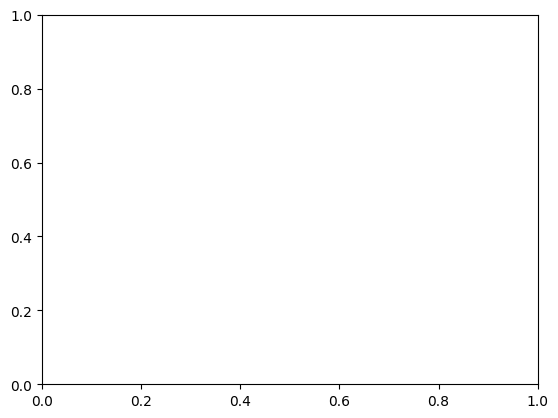

In [13]:
fig, ax = plt.subplots()

In [31]:
ax.clear()
ax.plot([1, 1], [0, 1])
ax.set_xticks([]); ax.set_yticks([]);
fig.tight_layout(pad=0)

In [33]:
import io

In [34]:
with io.BytesIO() as buff:
    fig.savefig(buff, format='raw')
    buff.seek(0)
    data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
w, h = fig.canvas.get_width_height()
im = data.reshape((int(h), int(w), -1))
im

array([[[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [227, 227, 227, 255],
        [241, 241, 241, 255],
        ...,
        [241, 241, 241, 255],
        [241, 241, 241, 255],
        [227, 227, 227, 255]],

       [[  0,   0,   0, 255],
        [241, 241, 241, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [241, 241, 241, 255]],

       ...,

       [[  0,   0,   0, 255],
        [241, 241, 241, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [241, 241, 241, 255]],

       [[  0,   0,   0, 255],
        [241, 241, 241, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [241, 241, 241, 255]],

       [[  0

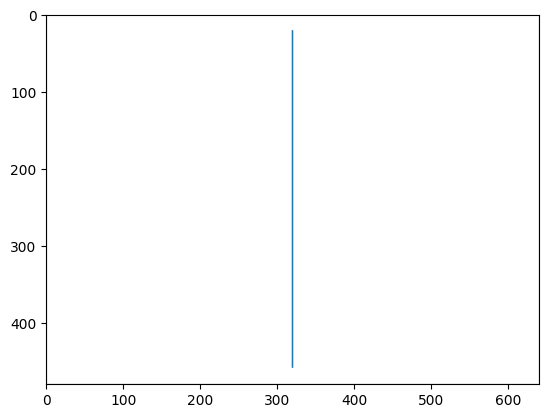

In [35]:
plt.imshow(im)

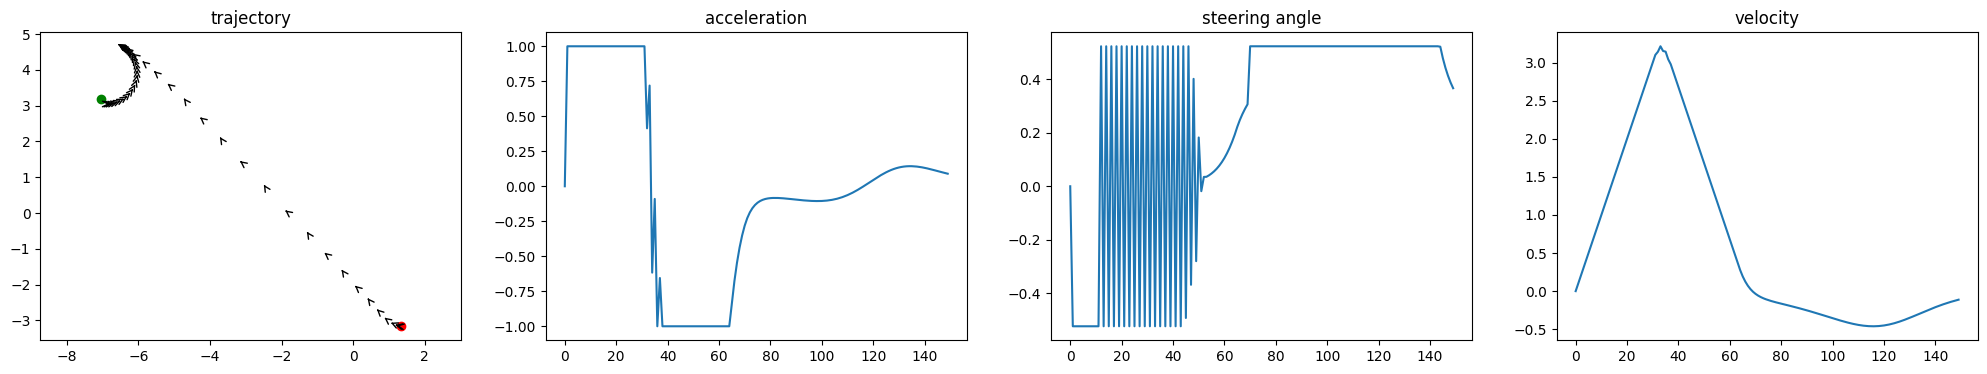

In [19]:
plt.figure(figsize=(25, 4))
plt.subplot(141)
plt.scatter(xs.T[0][1:], xs.T[1][1:], c='w', marker='.')
plt.plot(xs[0, 0], xs[0, 1], 'ro', xf[0], xf[1], 'go')
for i in range(0, xs.shape[0], 3):
    plt.annotate('',  xs[i, :2] + 0.2 * np.array([np.cos(xs[i, 2]), np.sin(xs[i, 2])]), 
                xs[i, :2], arrowprops=dict(arrowstyle='->'))
plt.axis('equal')
plt.title('trajectory')
plt.subplot(142)
plt.title('acceleration')
plt.plot(us[:, 0])
plt.subplot(143)
plt.title('steering angle')
plt.plot(us[:, 1])
plt.subplot(144)
plt.title('velocity')
plt.plot(xs[:, 3])

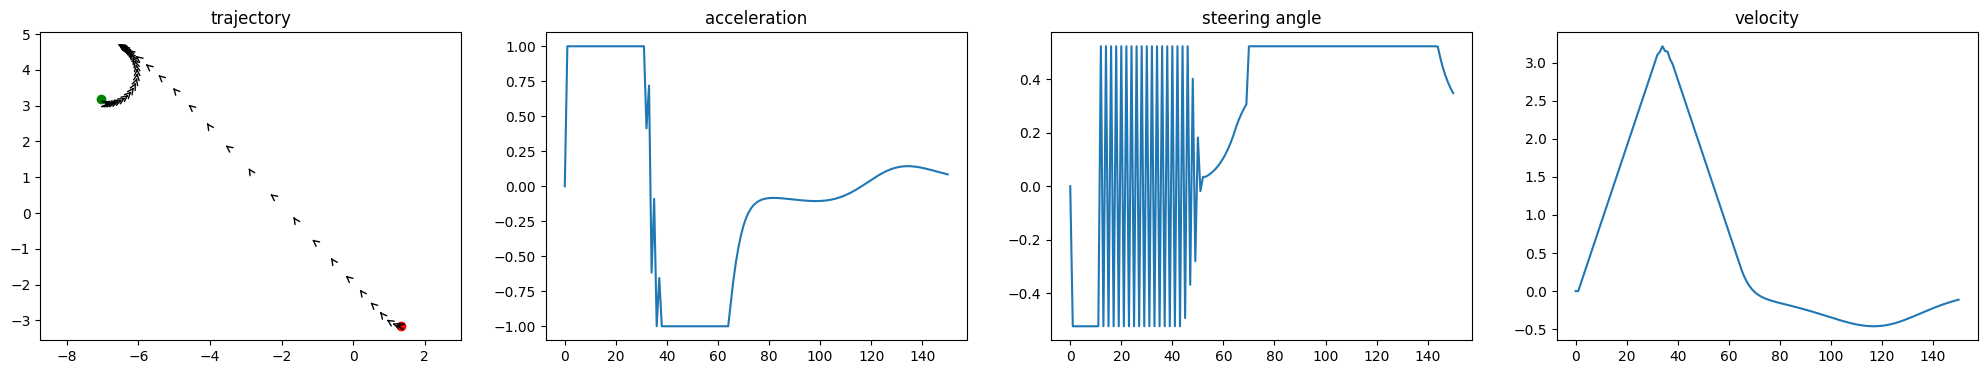

In [20]:
plt.figure(figsize=(25, 4))
plt.subplot(141)
plt.scatter(xts.T[0][1:], xts.T[1][1:], c='w', marker='.')
plt.plot(xts[0, 0], xts[0, 1], 'ro', xf[0], xf[1], 'go')
for i in range(0, xts.shape[0], 3):
    plt.annotate('',  xts[i, :2] + 0.2 * np.array([np.cos(xts[i, 2]), np.sin(xts[i, 2])]), 
                xts[i, :2], arrowprops=dict(arrowstyle='->'))
plt.axis('equal')
plt.title('trajectory')
plt.subplot(142)
plt.title('acceleration')
plt.plot(actions[:, 0])
plt.subplot(143)
plt.title('steering angle')
plt.plot(actions[:, 1])
plt.subplot(144)
plt.title('velocity')
plt.plot(xts[:, 3])

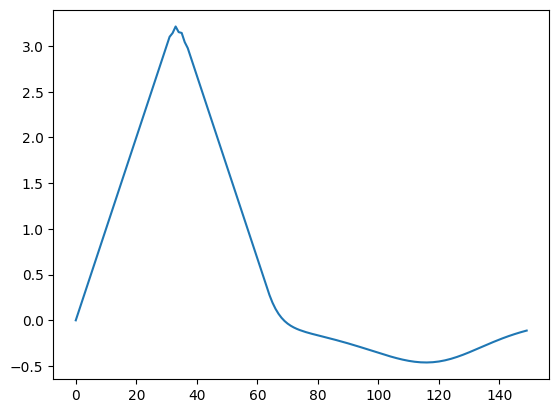

In [21]:
plt.plot(xs[:, -1])

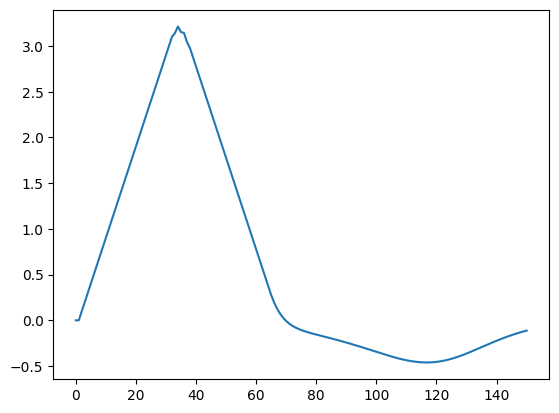

In [22]:
plt.plot(xts[:, -1])

# LQR (Discrete)

In [236]:
T = 15
Q = np.diag([2.5, 2.5, 0, 2.25])
R = np.diag([1.5, 0.25]) #np.diag([0.001, 0.1])
timepts = np.arange(0, T, dt)

x0 = np.random.uniform(low=[-5.0, -5.0, -np.pi, 1e-5],
                       high=[5.0, 5.0, np.pi, 1e-5]) # non-zero `u` and `x`
xs, us = x0.copy().reshape(1, -1), np.array([[0.00001, 0.00001]])
if 0 < x0[2] <= np.pi / 2:
    lb, ub = [5, 5], [10, 10]
elif np.pi / 2 < x0[2] <= np.pi:
    lb, ub = [-5, 5], [-10, 10] 
elif -np.pi / 2 < x0[2] <= 0:
    lb, ub = [5, -5], [10, -10]
elif -np.pi < x0[2] <= -np.pi / 2:
    lb, ub = [-5, -5], [-10, -10]
xf = np.random.uniform(low=[*(x0[:2] + lb), 1e-6, 1e-5],
                       high=[*(x0[:2] + ub), 1e-5, 1e-5])

for _ in timepts[:-1]:

    # Ad_t = np.array(Ad.subs(zip(states, xs[-1] + 1e-5)
    #                 ).subs(zip(inputs, us[-1] + 1e-5)       
    #                 ).subs(L, wheelbase), dtype=np.float32)
    # Bd_t = np.array(Bd.subs(zip(states, xs[-1] + 1e-5)
    #                 ).subs(zip(inputs, us[-1] + 1e-5)
    #                 ).subs(L, wheelbase), dtype=np.float32)  
    Ad_t = np.array(Ad.subs(zip(states, xs[-1] + 1e-5)
                    ).subs(zip(inputs, [1e-5, 1e-5])       
                    ).subs(L, wheelbase), dtype=np.float32)
    Bd_t = np.array(Bd.subs(zip(states, xs[-1] + 1e-5)
                    ).subs(zip(inputs, [1e-5, 1e-6])
                    ).subs(L, wheelbase), dtype=np.float32) 

    Kd, _, _ = dlqr(Ad_t, Bd_t, Q, R)
    u = -Kd @ np.subtract(xs[-1], xf)
    u = np.clip(u, [-max_accel, -max_steer], 
                [max_accel, max_steer])

    us = np.vstack([us, u])
    xs = np.vstack([xs, odeint(vehicle_update, xs[-1], [0, dt], 
                    args=(us[-1],), tfirst=True)[-1]])

**Visualisation**

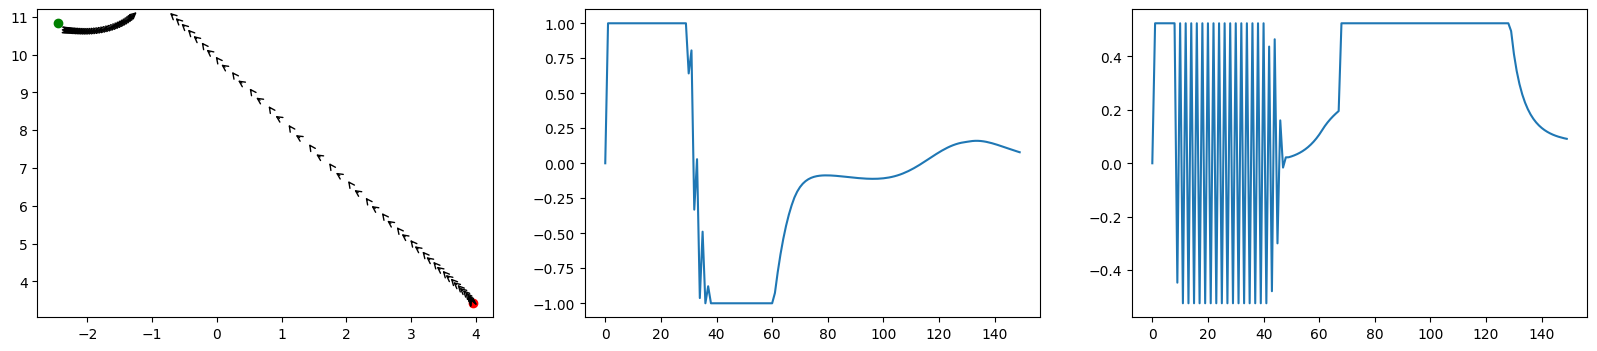

In [237]:
plt.figure(figsize=(20, 4))
plt.subplot(131)
# plt.scatter(xs.T[0][1:], xs.T[1][1:], c='k', marker='.')
plt.plot(xs[0, 0], xs[0, 1], 'ro', xf[0], xf[1], 'go')
for i in range(xs.shape[0]):
    plt.annotate('',  xs[i, :2] + 0.2 * np.array([np.cos(xs[i, 2]), np.sin(xs[i, 2])]), 
                xs[i, :2], arrowprops=dict(arrowstyle='->'))
# plt.axis([-10, 10, -10, 10])
plt.subplot(132)
plt.plot(us[:, 0])
plt.subplot(133)
plt.plot(us[:, 1])

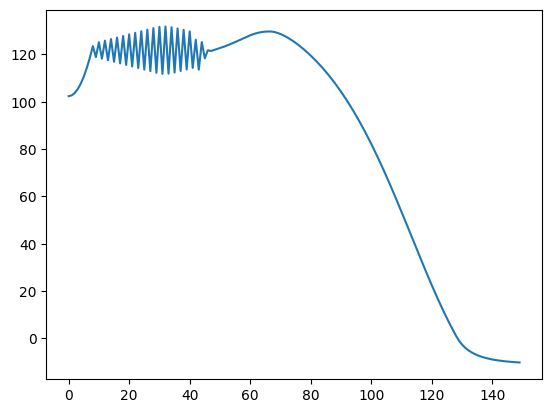

In [238]:
plt.plot(np.degrees(xs[:, 2]))

**NOTE:** In discrete case numerous tuning does not lead to reaching the exact location like the continuous case

In [ ]:
T = 60
c = 0.5
while c <= 50:
    p = 1e-15
    while p <= 1e0:
        try:
            x0 = np.array([-5.0, -5.0, 0.00001, 0.00001]) # non-zero `u` and `x`
            xs, us = x0.copy().reshape(1, -1), np.array([[0.00001, 0.00001]])
            xf = np.array([5.0, 5.0, 0.00001, 0.00001])

            Q = np.diag([0.001, 0.001, 0, 0.01])
            R = np.diag([0.1, 0.01]) #np.diag([0.001, 0.1])

            timepts = np.arange(0, T, dt)
            for _ in timepts[:-1]:

                Ad_t = np.array(Ad.subs(zip(states, xs[-1])
                                ).subs(zip(inputs, us[-1])       
                                ).subs(L, wheelbase), dtype=np.float32)
                Bd_t = np.array(Bd.subs(zip(states, xs[-1])
                                ).subs(zip(inputs, us[-1])
                                ).subs(L, wheelbase), dtype=np.float32)  

                Kd, _, _ = dlqr(Ad_t, Bd_t, Q, R)
                u = -Kd @ np.subtract(xs[-1], xf)
                u = np.clip(u, [-max_accel, -max_steer], 
                            [max_accel, max_steer])

                J = 2 * matrix(np.diag([1.0, 1.0, p]))
                f = matrix([-2.0 * u[0], -2.0 * u[1], p])
                Lf_h = dh(xs[-1]) @ A_t @ xs[-1]
                Lg_h = dh(xs[-1]) @ B_t
                G = matrix(np.array([
                        [-Lg_h[0], -Lg_h[1], 0.0],
                        [0.0, 0.0, -1.0],
                        [1.0, 0.0, 0.0],
                        [-1.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0],
                        [0.0, -1.0, 0.0]]), tc='d')
                b = matrix([c * h(xs[-1]) + Lf_h, 0.0, 
                            max_accel, max_accel, 
                            max_steer, max_steer], tc='d')
                sol = solvers.qp(J, f, G, b)
                if sol['status'] != 'optimal':
                    raise ValueError('unable to solve')
                u_safe = np.array(sol['x'][:-1]).ravel()

                us = np.vstack([us, u_safe])
                xs = np.vstack([xs, odeint(vehicle_update, xs[-1], [0, dt], 
                                args=(us[-1],), tfirst=True)[-1]])
            plt.gca().clear()
            plt.gca().add_patch(Circle((xc, yc), rr, color='r'))
            plt.plot(xs[0, 0], xs[0, 1], 'ro', xf[0], xf[1], 'ro')
            plt.scatter(xs.T[0][1:], xs.T[1][1:])
            plt.title(f" success for p = {p} and c = {c}")
            plt.axis('equal')
            plt.savefig(f'./lqr-cbf-qp-plots/c{c}p{p}.jpeg')
            clear_output(wait=True)
            display(plt.gcf())
        except Exception as e:
            plt.gca().clear()
            plt.gca().add_patch(Circle((xc, yc), rr, color='r'))
            plt.plot(xs[0, 0], xs[0, 1], 'ro', xf[0], xf[1], 'ro')
            plt.scatter(xs.T[0][1:], xs.T[1][1:])
            plt.title(f"({str(e)}) p = {p} and c = {c}")
            plt.axis('equal')
            clear_output(wait=True)
            display(plt.gcf())
        p *= 10
    c *= 1.2

        